In [1]:
import numpy as np

from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq, fftshift, ifftshift
from scipy import signal
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import scipy.signal as signal

import pandas as pd
import pickle
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style = 'white')
fig_size=(8,5)
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

cmap_name = 'coolwarm'

ADC_to_V = 0.13/(20e3)
V_to_ADC = 1/ADC_to_V

energies = np.array([0.1,0.32,0.5,0.71,1.0,1.6,2,2.5,3,3.6,4])

## 1. Open pulser data

In [2]:
## Dataframe pre-processing functions =================================================================================


def preprocess_dataframe(df):
    # Create lists to store processed data
    scans = []
    signal_list = []
    time_signal_ns_list = []
    waveform_list = []
    time_waveform_ns_list = []
    time_stamp_signal_list = []
    time_stamp_waveform_list = []
    
    # Process each row
    for idx, row in df.iterrows():
        scan = row['scan']
        scans.append(scan)
        
        # Process signal data
        signal = np.array(row['signal'])
        time_windowed_signal = np.array(row['time_signal'])
        

        # Convert time to start from 0 and convert to ns
        time_start = time_windowed_signal[0]
        processed_time_signal = (time_windowed_signal - time_start)
        
        # Process waveform data
        waveform = np.array(row['waveform'])
        time_windowed_waveform = np.array(row['time_waveform'])
        
        
        # Convert time to start from 0 and convert to ns
        time_start_wf = time_windowed_waveform[0]
        processed_time_waveform = (time_windowed_waveform - time_start_wf)  
        
        # Store processed data in lists
        signal_list.append(signal.tolist())
        time_signal_ns_list.append(processed_time_signal.tolist())
        waveform_list.append(waveform.tolist())
        time_waveform_ns_list.append(processed_time_waveform.tolist())
        time_stamp_signal_list.append(row['time_stamp_signal'])
        time_stamp_waveform_list.append(row['time_stamp_waveform'])
    
    # Create a new DataFrame all at once
    processed_df = pd.DataFrame({
        'scan': scans,
        'time_stamp_signal': time_stamp_signal_list,
        'signal': signal_list,
        'time_signal': time_signal_ns_list,
        'time_stamp_waveform': time_stamp_waveform_list,
        'waveform': waveform_list,
        'time_waveform': time_waveform_ns_list,
    })
    
    return processed_df


#-------------------------------------------------------------------------------------------------------------------

def sigmoid(t, A, k, t0, B):
    return A / (1 + np.exp(-k * (t - t0))) + B

#-------------------------------------------------------------------------------------------------------------------

def sort_by_waveform_amplitude(processed_df):
    # Create a copy of the processed DataFrame
    sorted_df = processed_df.copy()
    
    # List to store the amplitude values
    amplitudes = []
    var_amplitudes = []
    
    # Fit sigmoid to each waveform and extract the amplitude
    for idx, row in processed_df.iterrows():
        waveform = np.array(row['waveform'])
        time = np.array(row['time_waveform'])
        
        try:
            # Initial parameter guesses
            # A: estimate from max-min of waveform
            # k: moderate steepness
            # t0: midpoint of time range
            # B: minimum value of waveform
            p0 = [
                np.max(waveform) - np.min(waveform),  # A: amplitude guess
                0.1,                                   # k: steepness guess
                np.median(time),                       # t0: midpoint guess
                np.min(waveform)                       # B: offset guess
            ]
            
            # Set bounds to help convergence
            bounds = (
                [0, 0, np.min(time), -np.inf],          # Lower bounds
                [np.inf, np.inf, np.max(time), np.inf]  # Upper bounds
            )
            
            # Perform the fit
            popt, pcov = curve_fit(sigmoid, time, waveform, p0=p0, bounds=bounds, maxfev=10000)
            
            # Extract the amplitude (parameter A)
            amplitude = popt[0]
            amplitude_var = pcov[0][0]
            
        except Exception as e:
            print(f"Fitting failed for scan {row['scan']}: {e}")
            # Assign a default amplitude if fitting fails
            amplitude = 0
            amplitude_var = 0
        
        amplitudes.append(amplitude)
        var_amplitudes.append(amplitude_var)
    
    # Add the amplitude and variance columns to the DataFrame
    sorted_df['waveform_amplitude'] = amplitudes
    sorted_df['waveform_amplitude_var'] = var_amplitudes
    
    # Sort the DataFrame by amplitude
    sorted_df = sorted_df.sort_values(by='waveform_amplitude')
    
    # Reset the index
    sorted_df = sorted_df.reset_index(drop=True)
    
    return sorted_df

In [3]:
# crate a list of files names
data_path = '/Users/raffaelegaudio/JFET_model/energy_scans_pulser/'

signals = []
waveforms = []

for id in range(14):
    signal_file = data_path+'pulser_signal_p11_r006_'+str(id)+'.json' 
    signals.append(signal_file)

for id in range(14):
    waveform = data_path+'mean_pulser_wf_all_ICPC_p11_r006_'+str(id)+'.json' 
    waveforms.append(waveform)


# create dictionaries to store the data
signal_data = {}
waveform_data = {}

for i, file_path in enumerate(signals):
    with open(file_path, 'r') as file:
        signal_data[f'scan_{i}'] = json.load(file)

for i, file_path in enumerate(waveforms):
    with open(file_path, 'r') as file:
        waveform_data[f'scan_{i}'] = json.load(file)


# create a dataframe with all the data
df_data = []

for i in range(14):
    row_data = {
        'scan': i,
        'time_stamp_signal': signal_data[f'scan_{i}']['time_stamp'],
        'signal': signal_data[f'scan_{i}']['signal'],
        'time_signal': signal_data[f'scan_{i}']['time_windowed'],

    }

    row_data['time_stamp_waveform'] = waveform_data[f'scan_{i}']['time_stamp'] 
    row_data['waveform'] = waveform_data[f'scan_{i}']['signal']
    row_data['time_waveform'] = waveform_data[f'scan_{i}']['time_windowed']

    df_data.append(row_data)

# Create the DataFrame
df = pd.DataFrame(df_data)
processed_df = preprocess_dataframe(df)

# Attenuation factors-----------------------------------------------------------------------------------
def ratio(attenaution_db):
    return 10**(-attenaution_db/20.0)

attenuations_db = np.array([52,42,38,35,32,28,26,24,23,21,20,19,18,17])
ratios = np.array([ratio(i) for i in attenuations_db])


# Sort by waveform amplitue and apply attenuation function
sorted_df = sort_by_waveform_amplitude(processed_df)
pulser_df_ADC = sorted_df.copy()

# Before applying the attenuation, we need to remove the offset from the signal
# We take as offset value the first 20% of the signal
offset_idx = int(len(sorted_df['signal'][0]) * 0.2)

# Apply the scaling to each row
for i in range(len(ratios)):
    if i < len(pulser_df_ADC) and i < len(ratios):
        offset = np.mean(pulser_df_ADC.at[i, 'signal'][:offset_idx])                                    # evaluate offset
        pulser_df_ADC.at[i, 'signal'] = [val - offset for val in pulser_df_ADC.at[i, 'signal']]         # remove offset
        pulser_df_ADC.at[i, 'signal'] = [val * ratios[i] for val in pulser_df_ADC.at[i, 'signal']]      # apply attenuation factor
        pulser_df_ADC.at[i, 'signal'] = [val + offset for val in pulser_df_ADC.at[i, 'signal']]         # apply offset back 


pulser_df_ADC = pulser_df_ADC[:-3] # remove the last 3 scans (saturation)

pulser_df_ADC

,scan,time_stamp_signal,signal,time_signal,time_stamp_waveform,waveform,time_waveform,waveform_amplitude,waveform_amplitude_var
0,12,1.716273e+09,"[14964.736378141415, 14964.741401914278, 14964...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[15821, 15820, 15819, 15818, 15820, 15813, 158...","[0.0, 16.011436740525824, 32.02287348105892, 4...",713.502667,0.358019
1,1,1.716273e+09,"[14965.922795441442, 14965.827476053275, 14965...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[15726, 15725, 15725, 15727, 15725, 15727, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",2233.032399,3.174474
2,2,1.716273e+09,"[14965.50276816011, 14965.490178905991, 14965....","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[15754, 15751, 15756, 15757, 15755, 15758, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",3524.535605,7.700935
3,8,1.716272e+09,"[14964.884968289862, 14964.742705937058, 14964...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15795, 15794, 15789, 15790, 15791, 15788, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",4989.356879,15.142610
4,5,1.716272e+09,"[14958.52275212591, 14958.62322758317, 14958.6...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15894, 15896, 15891, 15892, 15894, 15894, 158...","[0.0, 16.011436740525824, 32.02287348105892, 4...",7024.002185,33.527276
5,13,1.716272e+09,"[14964.714623719543, 14965.033109455986, 14964...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15932, 15937, 15937, 15935, 15935, 15933, 159...","[0.0, 16.011436740525824, 32.02287348105892, 4...",11154.952539,79.948746
6,3,1.716272e+09,"[14965.83825232205, 14965.387183811785, 14965....","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15728, 15725, 15730, 15732, 15734, 15730, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",14035.834533,130.877064
7,7,1.716272e+09,"[14961.404396574042, 14961.46749230849, 14961....","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[15809, 15810, 15812, 15813, 15816, 15820, 158...","[0.0, 16.011436740525824, 32.02287348105892, 4...",17636.096877,207.490468
8,10,1.716271e+09,"[14963.278755551142, 14963.137166394265, 14962...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[15711, 15708, 15708, 15707, 15710, 15709, 157...","[0.0, 16.011436740525824, 32.02287348105892, 4...",19793.077590,245.216651
9,9,1.716271e+09,"[14967.231590910125, 14967.0533407225, 14967.4...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[15904, 15906, 15906, 15901, 15900, 15902, 159...","[0.0, 16.011436740525824, 32.02287348105892, 4...",24879.401406,373.502719


## 2. Frequency filter analysis

- remove baseline from both signals and waveforms
- compute the FFT for each pulser signal ($s(t)$) and the relative mean acquired waveform ($w(t)$):
$$
\mathcal{F}[s_i(t)](\omega); \qquad \mathcal{F}[w_i(t)](\omega); \qquad i \in N_{\text{signals}}
$$

- make the ratio between FFT(waveform) over FFT(signal) and than take the mean value:
$$
r_i(\omega) = \frac{ \mathcal{F}[w_i(t)](\omega)}{\mathcal{F}[s_i(t)](\omega)} \qquad \longrightarrow \qquad \text{Filter}(\omega) = \frac{1}{N_{\text{signals}}} \sum_{i=1}^{N_{\text{signals}}} r_i(\omega)
$$

In [4]:
def compute_fft(time_signal, sampling_rate, N=None):
    signal = np.array(time_signal)

    if not N:
        N = len(signal)

    fs = sampling_rate  

    # Full complex FFT
    fft_vals = fft(signal, N)
    fft_vals_shifted = fftshift(fft_vals)

    freqs = fftfreq(N, 1/fs)
    freqs_shifted = fftshift(freqs)

    # Get positive frequencies only
    pos_mask = freqs >= 0
    freqs = freqs[pos_mask]
    
    magnitude = np.abs(fft_vals[pos_mask]) * 2/N
    
    # Phase spectrum
    phase = np.angle(fft_vals)
    
    return fft_vals, fft_vals_shifted, freqs, freqs_shifted, magnitude, phase

In [5]:
data_time = pulser_df_ADC['time_signal'][0]
dt = (data_time[1] - data_time[0])*1e-9  # Sampling interval in seconds
N = 1400


signal_fft_vals = np.zeros((len(pulser_df_ADC),N)).astype(complex)
signal_fft_shift = np.zeros((len(pulser_df_ADC),N)).astype(complex)
signal_freqs = np.zeros((len(pulser_df_ADC),int(N/2))).astype(complex)
signal_freqs_shift = np.zeros((len(pulser_df_ADC),N)).astype(complex)
signal_magnitude = np.zeros((len(pulser_df_ADC),int(N/2))).astype(complex)


waveforms_fft_vals = np.zeros((len(pulser_df_ADC),N)).astype(complex)
waveforms_fft_shift = np.zeros((len(pulser_df_ADC),N)).astype(complex)
waveform_freqs = np.zeros((len(pulser_df_ADC),int(N/2))).astype(complex)
waveform_freqs_shift = np.zeros((len(pulser_df_ADC),N)).astype(complex)
waveform_magnitude = np.zeros((len(pulser_df_ADC),int(N/2))).astype(complex)


fft_ratios_waveform_signal = np.zeros((len(pulser_df_ADC),N)).astype(complex)


wf_offset_indx = int(len(pulser_df_ADC['waveform'][0]) * 0.2)


for k in range(len(pulser_df_ADC)):
    signal_fft_vals[k,:], signal_fft_shift[k,:], signal_freqs[k,:], signal_freqs_shift[k,:], signal_magnitude[k,:], _ = compute_fft((pulser_df_ADC['signal'][k]-np.mean(pulser_df_ADC['signal'][k][:wf_offset_indx])), 1/dt, N=N)
    waveforms_fft_vals[k,:], waveforms_fft_shift[k,:], waveform_freqs[k,:], waveform_freqs_shift[k,:], waveform_magnitude[k,:], _ = compute_fft((pulser_df_ADC['waveform'][k]-np.mean(pulser_df_ADC['waveform'][k][:wf_offset_indx])), 1/dt, N=N)
    fft_ratios_waveform_signal[k,:] = waveforms_fft_vals[k,:]/signal_fft_vals[k,:]


filtr=np.mean(fft_ratios_waveform_signal, axis=0)

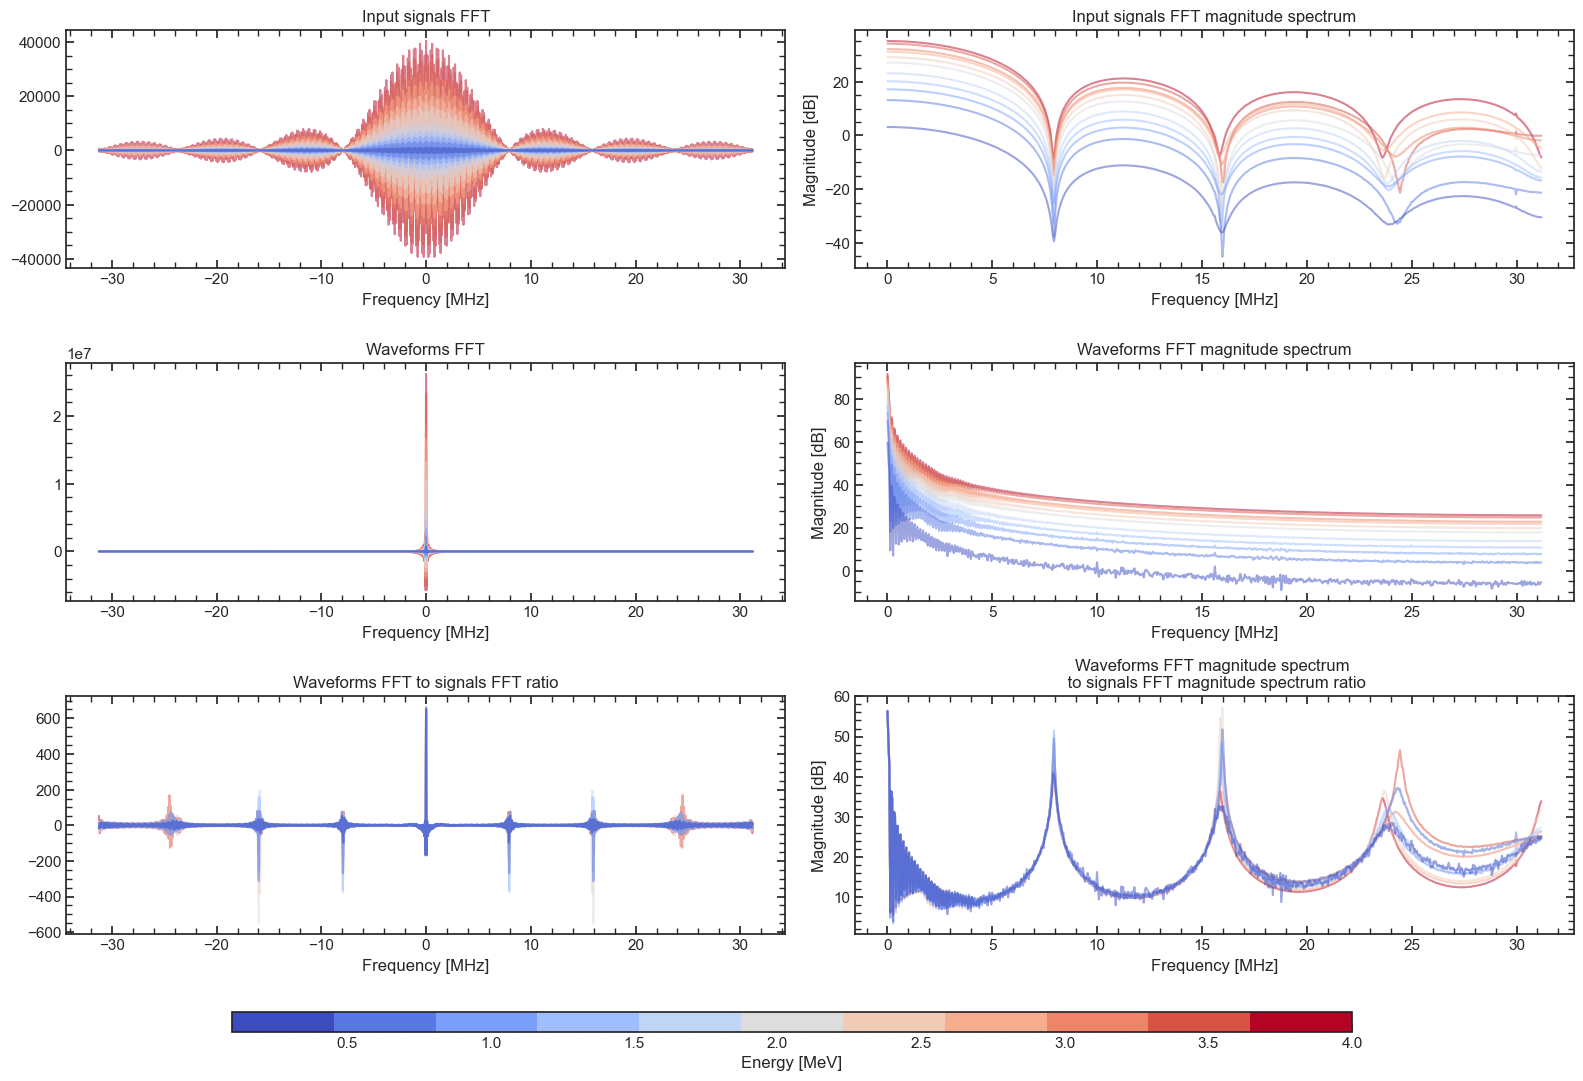

In [6]:
cmap = cm.get_cmap(cmap_name, len(pulser_df_ADC))#.reversed()

plt.figure(figsize=(16, 10))

plt.subplot(3, 2, 1)
plt.title('Input signals FFT')
for i in range(len(pulser_df_ADC))[::-1]:
    plt.plot(signal_freqs_shift[i,:]*1e-6, signal_fft_shift[i,:], label=f'signal {i+1}', alpha=0.5, color =cmap(i))
plt.xlabel('Frequency [MHz]')


plt.subplot(3, 2, 2)
plt.title('Input signals FFT magnitude spectrum')
for i in range(len(pulser_df_ADC))[::-1]:
    plt.plot(signal_freqs[i,:]*1e-6, 20*np.log10(signal_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5, color =cmap(i))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')


plt.subplot(3, 2, 3)
plt.title('Waveforms FFT')
for i in range(len(pulser_df_ADC))[::-1]:
    plt.plot(waveform_freqs_shift[i,:]*1e-6, waveforms_fft_shift[i,:], alpha=0.5, label=f'waveform {i+1}', color =cmap(i))
plt.xlabel('Frequency [MHz]')


plt.subplot(3, 2, 4)
plt.title('Waveforms FFT magnitude spectrum')
for i in range(len(pulser_df_ADC))[::-1]:
    plt.plot(waveform_freqs[i,:]*1e-6, 20*np.log10(waveform_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5, color =cmap(i))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')


plt.subplot(3, 2, 5)
plt.title('Waveforms FFT to signals FFT ratio')
for i in range(len(pulser_df_ADC))[::-1]:
    plt.plot(waveform_freqs_shift[i,:]*1e-6,fftshift(fft_ratios_waveform_signal[i,:]), label=f'signal {i+1}', alpha=0.5, color =cmap(i))
plt.xlabel('Frequency [MHz]')


plt.subplot(3, 2, 6)
plt.title('Waveforms FFT magnitude spectrum \n to signals FFT magnitude spectrum ratio')
for i in range(len(pulser_df_ADC))[::-1]:
    plt.plot(signal_freqs[i,:]*1e-6, 20*np.log10(waveform_magnitude[i,:]) - 20*np.log10(signal_magnitude[i,:]), label=f'signal {i+1}', alpha=0.5, color =cmap(i))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')

plt.tight_layout();


# colorbar 
norm = plt.Normalize(min(energies), max(energies))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar_ax = plt.gcf().add_axes([0.15, -0.04, 0.7, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Energy [MeV]')



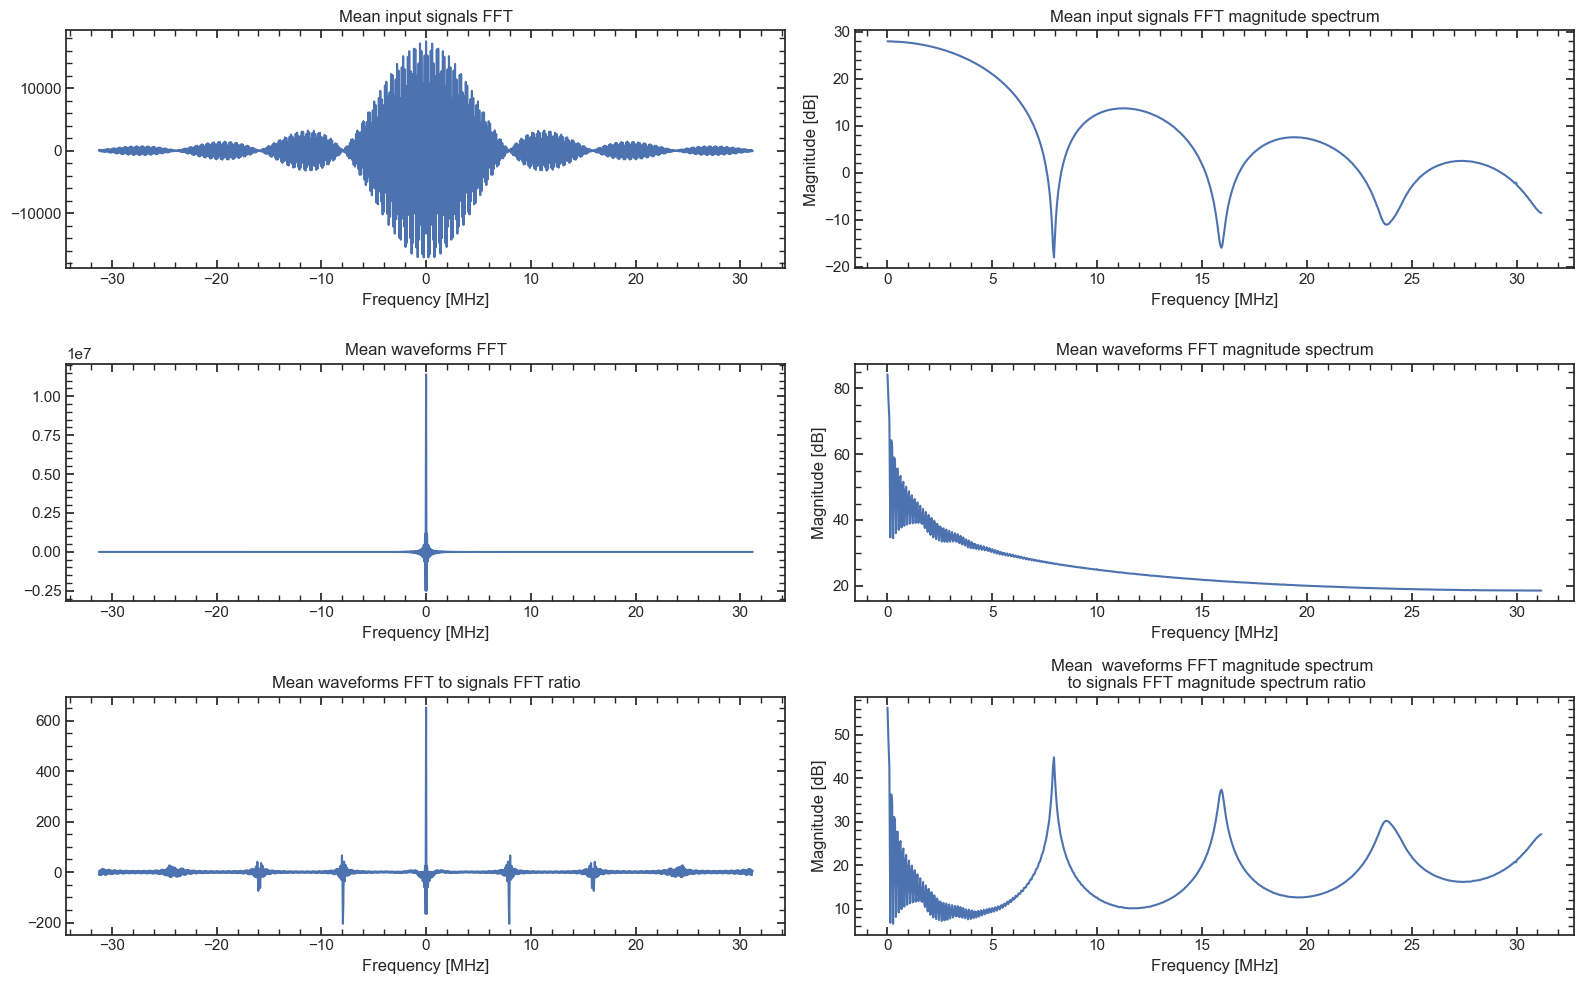

In [7]:
plt.figure(figsize=(16, 10))

plt.subplot(3, 2, 1)
plt.title('Mean input signals FFT')
plt.plot(signal_freqs_shift[i,:]*1e-6, np.mean(signal_fft_shift, axis=0))
plt.xlabel('Frequency [MHz]')


plt.subplot(3, 2, 2)
plt.title('Mean input signals FFT magnitude spectrum')
plt.plot(signal_freqs[0]*1e-6, 20*np.log10(np.mean(signal_magnitude, axis=0)))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')


plt.subplot(3, 2, 3)
plt.title('Mean waveforms FFT')
plt.plot(waveform_freqs_shift[i,:]*1e-6, np.mean(waveforms_fft_shift, axis=0)[:])
plt.xlabel('Frequency [MHz]')

plt.subplot(3, 2, 4)
plt.title('Mean waveforms FFT magnitude spectrum')
plt.plot(waveform_freqs[0]*1e-6, 20*np.log10(np.mean(waveform_magnitude, axis=0)))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')


plt.subplot(3, 2, 5)
plt.title('Mean waveforms FFT to signals FFT ratio')
plt.plot(waveform_freqs_shift[i,:]*1e-6,fftshift(np.mean(fft_ratios_waveform_signal, axis=0)))
plt.xlabel('Frequency [MHz]')


plt.subplot(3, 2, 6)
plt.title('Mean  waveforms FFT magnitude spectrum \n to signals FFT magnitude spectrum ratio')
plt.plot(signal_freqs[0]*1e-6, 20*np.log10(np.mean(waveform_magnitude, axis=0)) - 20*np.log10(np.mean(signal_magnitude, axis=0)))
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')

plt.tight_layout();

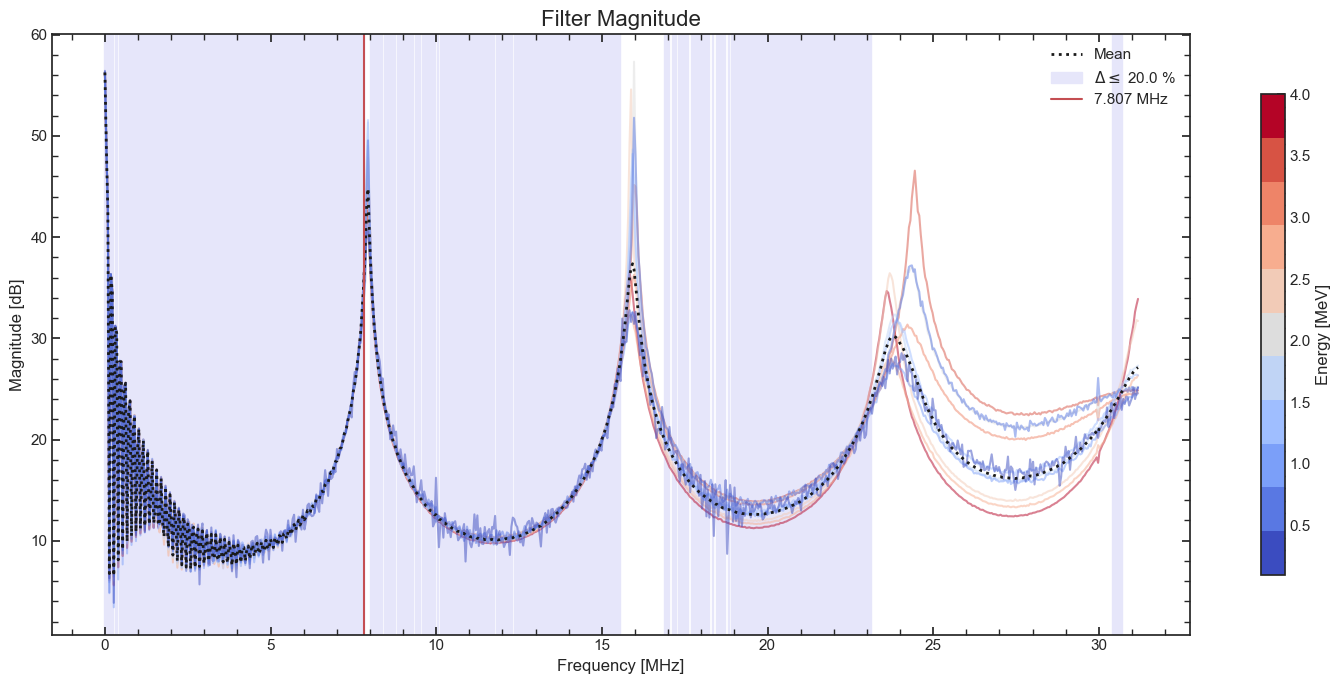

In [8]:
def fft_ratio_similarity(fft_ratios, freqs, difference_percentage=0.1):
    N = fft_ratios.shape[1]
    abs_ratios = np.abs(fftshift(fft_ratios))[:,int(N/2):]
    mask = np.all(np.abs(abs_ratios-np.mean(abs_ratios, axis=0))<=np.mean(abs_ratios,axis=0)*difference_percentage, axis=0)
    if len(freqs) == N:
        freqs = freqs[int(N/2):]
    return (freqs[mask]*1e-6).astype(float)


def create_frequency_bands(frequencies, band_width=0.02):
    if len(frequencies) == 0:
        return []
    
    # Sort frequencies
    sorted_freqs = np.sort(frequencies)
    bands = []
    
    for freq in sorted_freqs:
        band_start = freq - band_width/2
        band_end = freq + band_width/2
        
        # Check if this band overlaps with the previous one
        if bands and band_start < bands[-1][1]:
            # Merge with previous band
            bands[-1] = (bands[-1][0], band_end)
        else:
            # Create new band
            bands.append((band_start, band_end))
    
    return bands

#---------------------------------------------------------------------------------------------------------------------------------------

diff_perc = 0.2
similarity = fft_ratio_similarity(fft_ratios_waveform_signal, signal_freqs[0], difference_percentage=diff_perc)

band_width = (waveform_freqs[0,1]-waveform_freqs[0,0]).astype(float)*1e-6
positive_bands = create_frequency_bands(similarity, band_width)

v_cut = 7.80691964

color_band = 'lavender'
#color_band = 'lightgreen'
cmap = cm.get_cmap(cmap_name, len(pulser_df_ADC))#.reversed()


plt.figure(figsize=(15,7))
plt.title('Filter Magnitude', fontsize=16)
for i in range(11)[::-1]:
    plt.plot(signal_freqs[i,:]*1e-6, 20*np.log10(waveform_magnitude[i,:]) - 20*np.log10(signal_magnitude[i,:]), alpha=0.5, color=cmap(i))
plt.plot(signal_freqs[0]*1e-6, 20*np.log10(np.mean(waveform_magnitude, axis=0)) - 20*np.log10(np.mean(signal_magnitude, axis=0)), alpha=1, label='Mean', color='k', ls=':', lw=2)

# Plot the bands with lower z-order
for start, end in positive_bands[:-1]:
    plt.axvspan(start, end, color=color_band, alpha=1, zorder=0)
plt.axvspan(positive_bands[-1][0], positive_bands[-1][1], color=color_band, alpha=1, label=f'$\Delta \leq$ {diff_perc*100} %', zorder=0)
plt.axvline(v_cut, color='r', linestyle='-', lw=1.5, label=f'{np.round(v_cut,3)} MHz')

plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')
plt.legend(frameon=False)


ax = plt.gca()
ax.tick_params(axis='both', which='major', zorder=10)
ax.tick_params(axis='both', which='minor', zorder=10)

norm = plt.Normalize(min(energies), max(energies))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8)
cbar.set_label('Energy [MeV]')
plt.tight_layout()

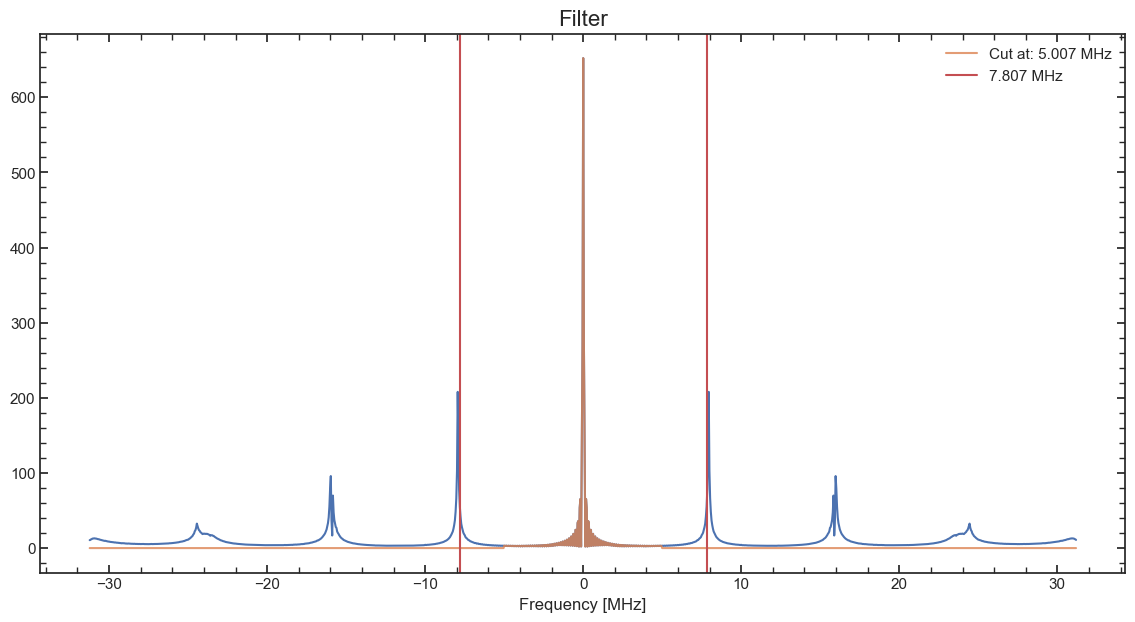

In [9]:
def freq_cuts(filter, percentage=None, f_cut=None, f_sampl = 1/16 *1e9):
    f_n = f_sampl/2

    if f_cut and not percentage:     
        percentage = f_cut/f_n

    if percentage > 1:
        raise ValueError('percentage must be smaller than 1.')
    
    elif percentage == 0:
        return np.zeros_like(filter), 0

    else:
        indx = int(np.ceil(len(filter)/2 *percentage))

        filter_copy = np.copy(filter)
        filter_copy[indx:-indx] = 0

    freqs = np.linspace(0, f_n, int(len(filter)/2))
    cut_freq = freqs[int(np.ceil(len(filtr)/2 *percentage))].real*1e-6

    return filter_copy, cut_freq


#------------------------------------------------------------------------------------------------------------------------------------------------------------

f_cut = 5*1e6 #Hz
filtr_cutted, cut_freq = freq_cuts(filtr, f_cut=f_cut)


plt.figure(figsize=(14,7))
plt.title('Filter', fontsize=16)
plt.plot(waveform_freqs_shift[0]*1e-6, np.abs(fftshift(filtr)))
plt.plot(waveform_freqs_shift[0]*1e-6, np.abs(fftshift(filtr_cutted)), label=f'Cut at: {np.round(cut_freq, 3)} MHz', alpha=0.8)
plt.axvline(v_cut, color='r', linestyle='-', lw=1.5, label=f'{np.round(v_cut,3)} MHz')
plt.axvline(-v_cut, color='r', linestyle='-', lw=1.5)
plt.xlabel('Frequency [MHz]')
plt.legend(frameon=False);


## 3. Building the Filter

In [10]:
df_data = pd.DataFrame({'time': pulser_df_ADC['time_signal'], 'input_signal': pulser_df_ADC['signal'], 'waveform': pulser_df_ADC['waveform']})
df_data.to_pickle('./filter_data.pkl')

In [11]:
def cc4_filter_builder(N):
    df = pd.read_pickle('./filter_data.pkl')
    fs = (df['time'][0][1] - df['time'][0][0]) * 1e-9 # convert into seconds 

    freqs = fftfreq(N, fs)
    freqs_shifted = fftshift(freqs)
    freqs = freqs[freqs >= 0]

    signal_fft_vals = np.zeros((len(df),N)).astype(complex)
    waveforms_fft_vals = np.zeros((len(df),N)).astype(complex)

    fft_ratios_waveform_signal = np.zeros((len(df),N)).astype(complex)

    wf_offset_indx = int(len(df['waveform'][0]) * 0.2)

    for k in range(len(df)):
        signal_fft_vals[k,:] = fft((df['input_signal'][k]-np.mean(df['input_signal'][k][:wf_offset_indx])), N)
        waveforms_fft_vals[k,:] = fft((df['waveform'][k]-np.mean(df['waveform'][k][:wf_offset_indx])), N)
        fft_ratios_waveform_signal[k,:] = waveforms_fft_vals[k,:]/signal_fft_vals[k,:]

    filter=np.mean(fft_ratios_waveform_signal, axis=0)

    return filter, freqs, freqs_shifted

## 4. Test with GeSim data

In [12]:
## GeSim data pre-processing functions =================================================================================


def fill_trailing_zeros_with_max(arr):
    result = arr.copy()
    for i, row in enumerate(result):
        max_val = np.max(row)
        
        # Find indices of non-zero elements
        nonzero_indices = np.nonzero(row)[0]
        
        if len(nonzero_indices) > 0:
            # Get the index after the last non-zero element
            last_nonzero_idx = nonzero_indices[-1]
            # Fill trailing zeros
            result[i, last_nonzero_idx + 1:] = max_val
    
    return result


def apply_padding(array, padding_length, position="left", paddign_value=0):
    padding_base = np.ones((array.shape[0], padding_length))

    if type(paddign_value) is not int and type(paddign_value) is not float: 
        if len(paddign_value) != array.shape[0]:
            raise ValueError("Padding value must match the number of columns in the array.")
        else:
            padding = (padding_base.T * paddign_value).T
    else:
        padding = padding_base * paddign_value

    if position == "left":
        return np.concatenate((padding, array), axis=1)
    elif position == "right":
        return np.concatenate((array, padding), axis=1)
    elif position == "both":
        return np.concatenate((padding, array, padding), axis=1)
    else:
        raise ValueError("Position must be 'left', 'right', or 'both'.")
    

# open the file with energy depositions
max_len = 1600
n_signals = 5

energy_depositions = np.zeros((n_signals, max_len))

dict_signals = {}

with open("/Users/raffaelegaudio/JFET_model/signals_gesim.txt", "r") as f:
    for line in f:
        kay = str(line.strip()[0:8])
        val = line.strip()[11:-1]
        dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


In [13]:
# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail

dict_signals[kay] = val

for idx, kay in enumerate(dict_signals.keys()):
    tmp = dict_signals[kay]
    tmp = tmp.replace(" ", "")
    tmp = tmp.replace("eV", "")
    tmp = tmp.split(",")
    for i in range(len(tmp)):
        energy_depositions[idx, i] = float(tmp[i])


# extend the max value of the energy deposition in the original array
energy_depositions_tailed = fill_trailing_zeros_with_max(energy_depositions)

# apply padding at the beginning of the array (baseline)
padding_length_baseline = int(22400*0.2)
energy_depositions_padded = apply_padding(energy_depositions_tailed, padding_length_baseline, position="left", paddign_value=0)    # baseline

# applay padding at the end of the array (tail)
max_energy = []
for i in range(n_signals):
    max_energy.append(np.max(energy_depositions_padded[i]))
tails = np.array(max_energy) 
padding_length_tail = int(22400*0.8)
energy_depositions_padded = apply_padding(energy_depositions_padded, padding_length_tail, position="right", paddign_value=tails) # tail

In [14]:
data_time = df_data['time'][0]
dt=(data_time[1]-data_time[0])*1e-9

print(len(data_time))
print(max(data_time))

1400
22400.0


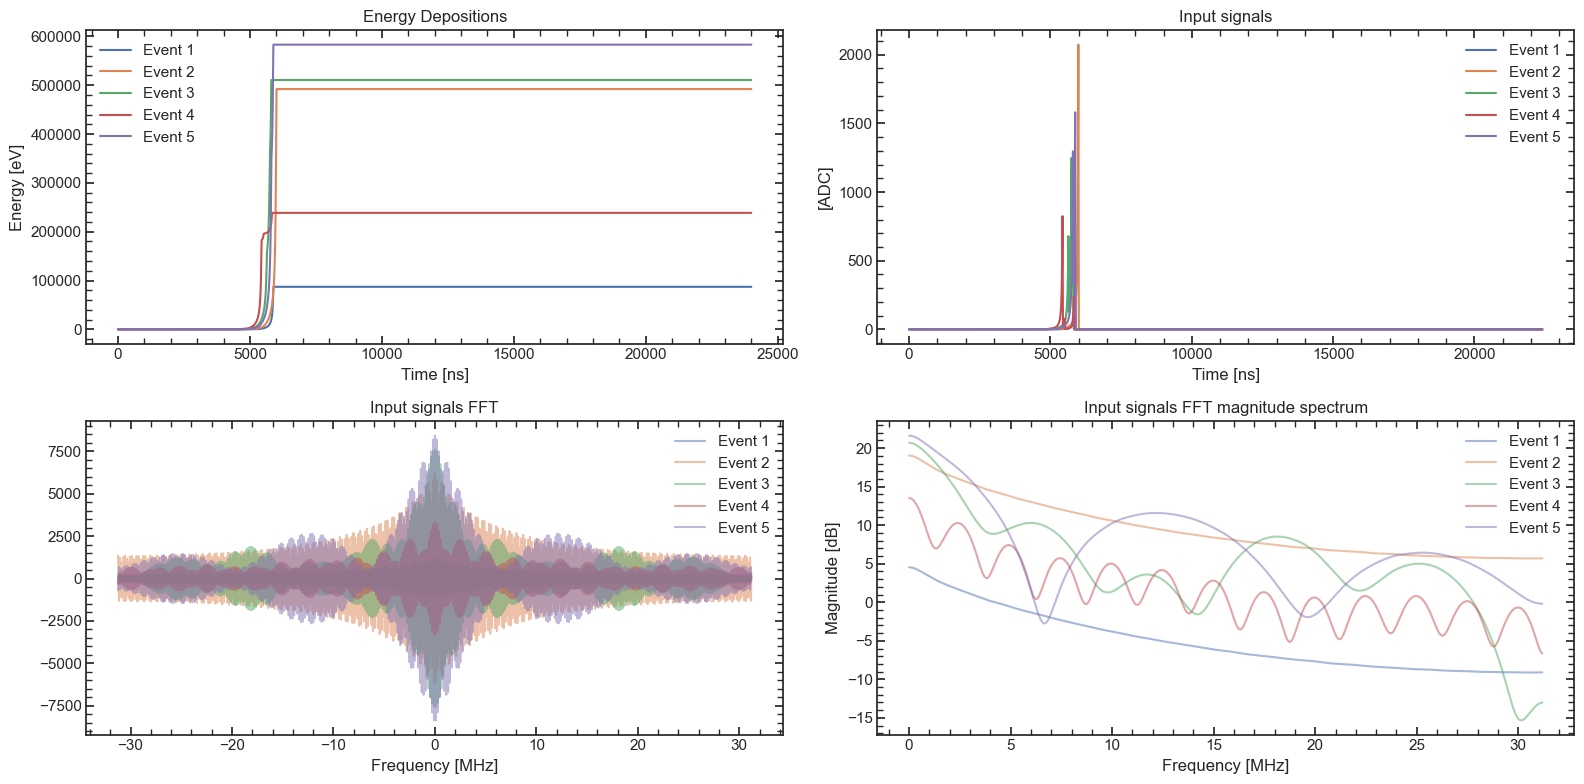

In [15]:
q = 1.6e-19
W = 1
R = 10000e9

N=len(data_time)

current = np.gradient(energy_depositions_padded, axis=1)/W * q  # in A
voltage = current[:,:int(max(data_time))] * R
voltage = voltage[:,::16]

voltage_ADC = voltage * V_to_ADC

voltage_fft_vals = np.zeros((len(pulser_df_ADC),N)).astype(complex)
voltage_fft_shift = np.zeros((len(pulser_df_ADC),N)).astype(complex)
voltage_freqs = np.zeros((len(pulser_df_ADC),int(N/2))).astype(complex)
voltage_freqs_shift = np.zeros((len(pulser_df_ADC),int(N))).astype(complex)
voltage_magnitude = np.zeros((len(pulser_df_ADC),int(N/2))).astype(complex)

for i in range(voltage.shape[0]):
    voltage_fft_vals[i,:], voltage_fft_shift[i,:], voltage_freqs[i,:], voltage_freqs_shift[i,:], voltage_magnitude[i,:], _ = compute_fft(voltage_ADC[i,:], 1/dt, N=N)


#------------------------------------------------------------------------------------------------------------------------------------------------------------


plt.figure(figsize=(16, 8))
for i in range(voltage_ADC.shape[0]):

    plt.subplot(2, 2, 1)
    plt.plot(energy_depositions_padded[i], label=f'Event {i+1}')
    plt.title('Energy Depositions')
    plt.xlabel('Time [ns]')
    plt.ylabel('Energy [eV]')
    plt.legend(frameon=False)

    plt.subplot(2, 2, 2)
    plt.title('Input signals')
    plt.plot(data_time, voltage_ADC[i,:], label=f'Event {i+1}')
    plt.ylabel('[ADC]')
    plt.xlabel('Time [ns]')
    plt.legend(frameon=False)

    plt.subplot(2, 2, 3)
    plt.title('Input signals FFT')
    plt.plot(voltage_freqs_shift[i,:]*1e-6, voltage_fft_shift[i,:], label=f'Event {i+1}', alpha=0.5)
    plt.xlabel('Frequency [MHz]')
    plt.legend(frameon=False)
    

    plt.subplot(2, 2, 4)
    plt.title('Input signals FFT magnitude spectrum')
    plt.plot(voltage_freqs[i,:]*1e-6, 20*np.log10(voltage_magnitude[i,:]), label=f'Event {i+1}', alpha=0.5)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend(frameon=False)

plt.tight_layout()

Real cutting freq: 5.007 MHz


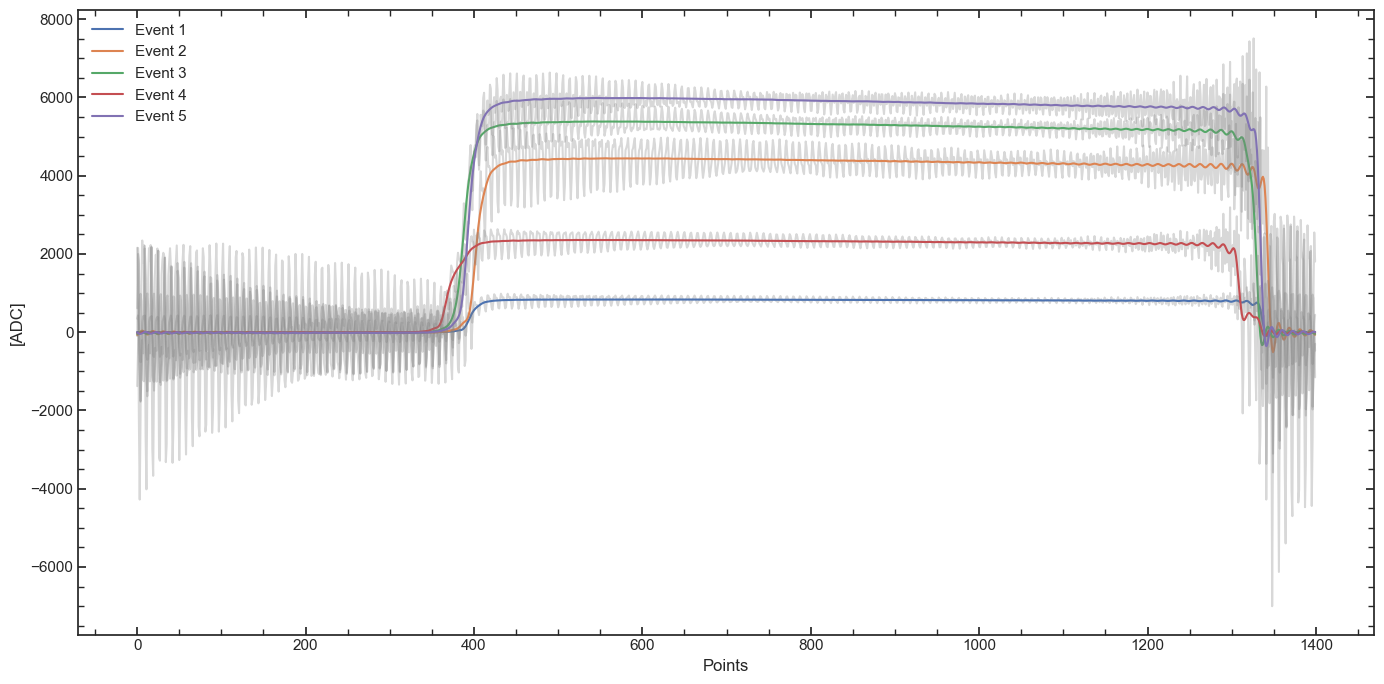

In [ ]:
f_cut = 5*1e6 #Hz


cc4_filter, cc4_freqs, cc4_freqs_shift = cc4_filter_builder(N)              # build the full filter 
filtr_cutted_gesim, cut_freq_gesim = freq_cuts(cc4_filter, f_cut=f_cut)     # cut the filter --> low pass filter

print(f'Real cutting freq: {np.round(cut_freq_gesim,3)} MHz')


plt.figure(figsize=(14, 7))
for i in range(voltage.shape[0]):
    plt.plot(ifft(voltage_fft_vals[i,:]*cc4_filter), color= 'grey', alpha=0.3)
    plt.plot(ifft(voltage_fft_vals[i,:]*filtr_cutted_gesim), label=f'Event {i+1}', color= 'C'+str(i))
    plt.xlabel('Points')
    plt.ylabel('[ADC]')
    plt.legend(frameon=False)

plt.tight_layout()

In [17]:
def cc4(detector_signal, dt, units="ADC", ADC_offset = 15000, calibration_applied=True):
    ADC_to_V = 0.13/(20e3)
    V_to_ADC = 1/ADC_to_V
    ADC_bias = ADC_offset
    R_f = 1e9
    C_f = 400e-15
    dc_bias = -3.52
    with open('total_transfer_function_params.pkl', 'rb') as f:
        total_transfer_loaded = pickle.load(f)
    with open('calibration_curve_params.pkl', 'rb') as f:
        calibration_curve_loaded = pickle.load(f)
    
    def integrate_signal(R_f, C_f, input_signal, dt, decay=True):
        tau = R_f * C_f             
        offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
        output_signal = np.zeros_like(input_signal)
        effective_signal = input_signal - offset  
        if decay:
            decay_factor = np.exp(-dt /tau)
        else: 
            decay_factor = 1
        for i in range(1, len(input_signal)):
            input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
            output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
        
        return -output_signal
    
    # Handle both 1D and 2D input arrays
    detector_signal = np.atleast_2d(detector_signal)
    is_1d_input = detector_signal.shape[0] == 1 and len(detector_signal.shape) == 2
    
    
    waveforms = np.zeros(detector_signal.shape)
    
    for i in range(detector_signal.shape[0]):
        input_signal = detector_signal[i,:] + dc_bias
        output_csa = total_transfer_loaded(input_signal)
        integrated_signal = integrate_signal(R_f, C_f, output_csa, dt, decay=True)
        
        if calibration_applied:
            conversion = calibration_curve_loaded(integrated_signal)
            waveforms[i,:] = (np.array([s*c for s,c in zip(integrated_signal, conversion)]))
        else:
            waveforms[i,:] = integrated_signal
            
    # Convert output units
    if units == "ADC":
        result = (waveforms * V_to_ADC) + ADC_bias    
    elif units == "V":
        result = waveforms 
    else:
        raise ValueError("Units must be 'ADC' or 'V'.")
    
    # Return 1D array if input was 1D
    if is_1d_input:
        return result[0]
    else:
        return result

#------------------------------------------------------------------------------------------------------------------------------------------------------------

def moving_average(data, window_size):
    # Convert to numpy array
    data = np.array(data)
    
    # Validate window size
    if window_size <= 0:
        raise ValueError("Window size must be positive")
    
    # For 2D arrays, check window size against number of columns
    if data.ndim == 2:
        if window_size > data.shape[1]:
            raise ValueError("Window size cannot be larger than number of columns")
    else:
        if window_size > len(data):
            raise ValueError("Window size cannot be larger than data length")
    
    # 1D arrays
    if data.ndim == 1:
        result = np.convolve(data, np.ones(window_size)) / window_size
        return result[int(np.floor(window_size/2)):-int(np.floor(window_size/2))]
    
    # 2D arrays - calculate moving average along rows (axis=1)
    elif data.ndim == 2:
        n_rows, n_cols = data.shape
        result_cols = n_cols + window_size - 1
        result = np.zeros((n_rows, result_cols))
        
        for row in range(n_rows):
            result[row] = np.convolve(data[row], np.ones(window_size)) / window_size
        
        return result[:,int(np.floor(window_size/2)):-int(np.floor(window_size/2))]
    
    else:
        raise ValueError("Function supports only 1D and 2D arrays")


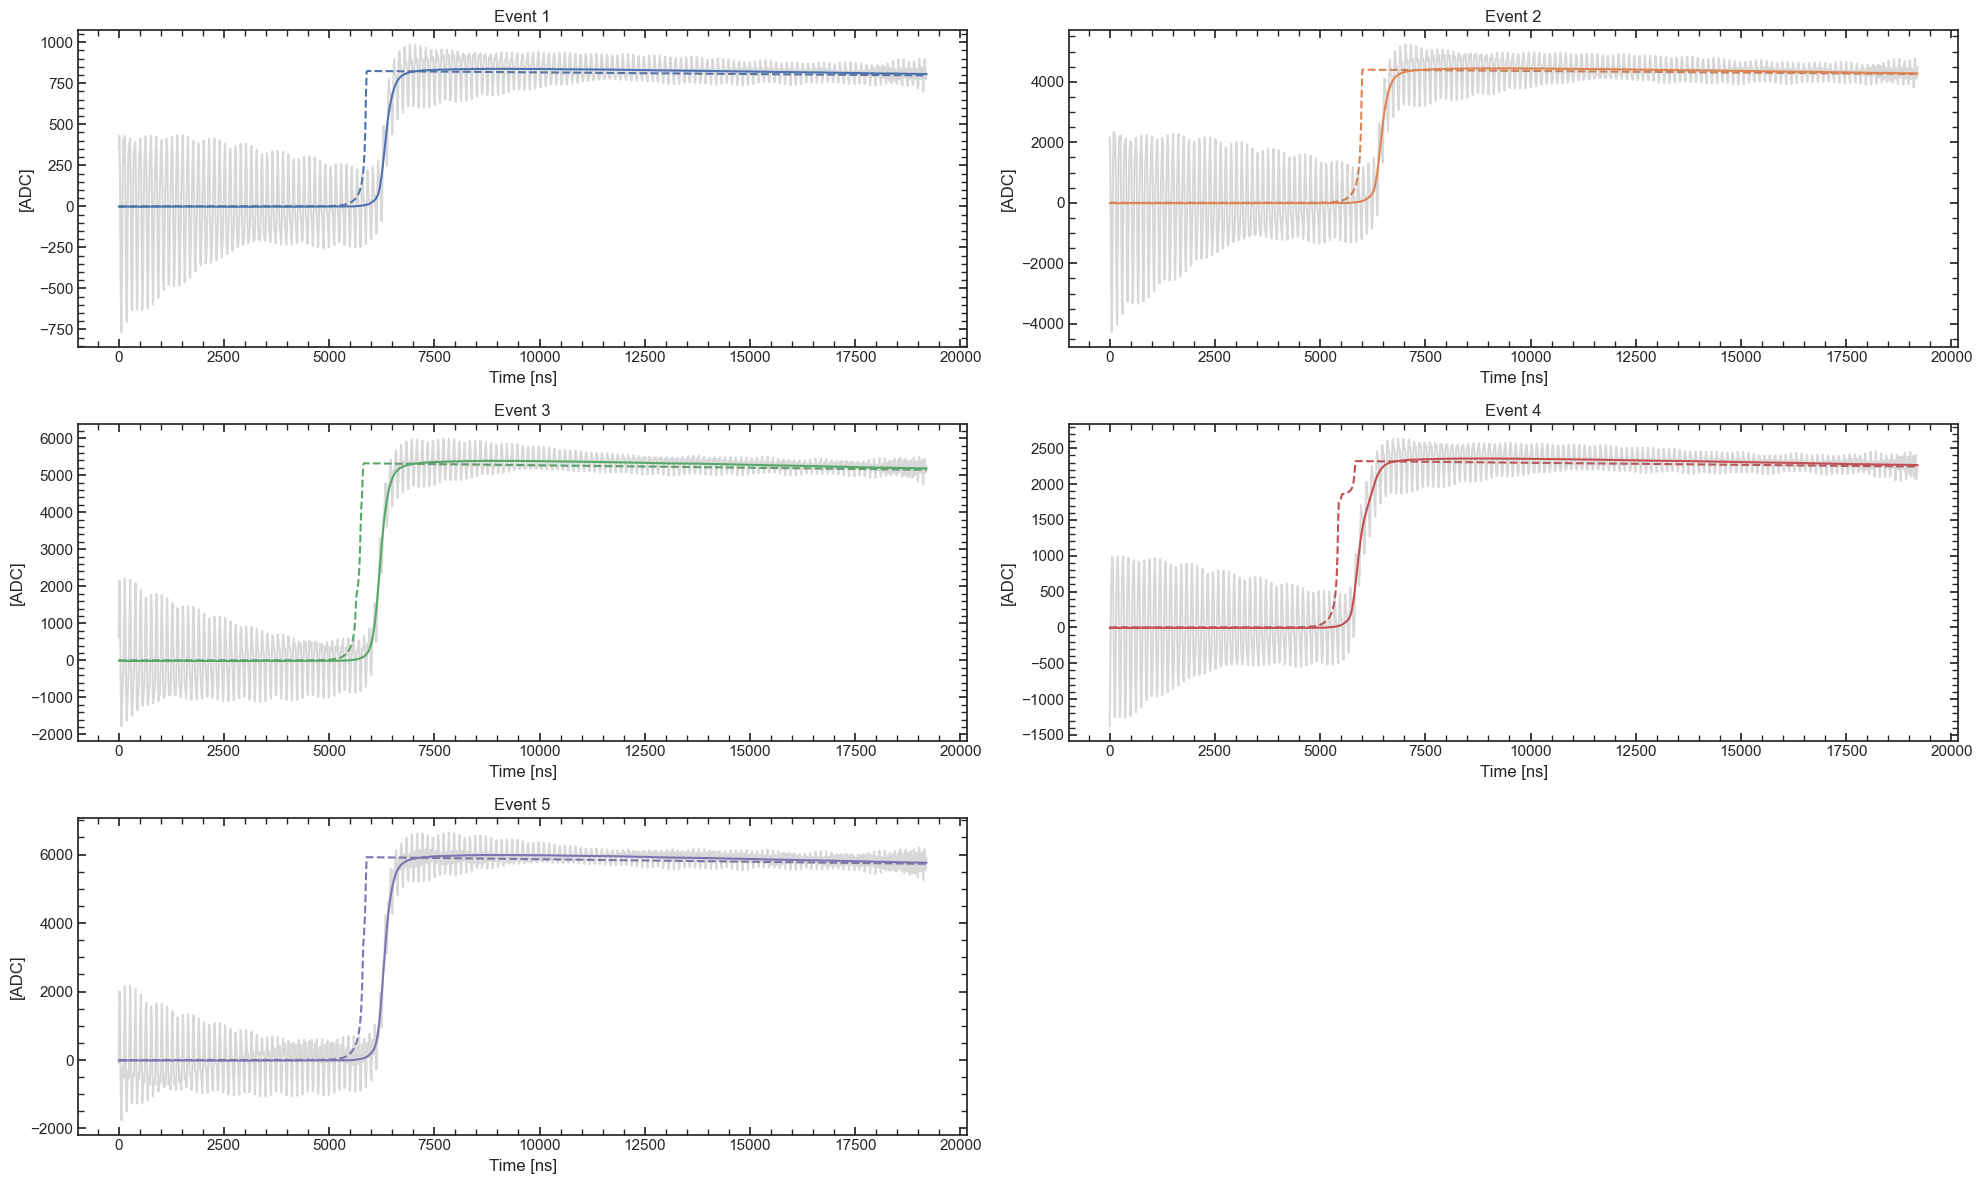

In [ ]:
waveforms = cc4(voltage, dt, units="ADC", ADC_offset=0)                                 # simulated waveforms with no freqs effects
wfs=waveforms[:,:1200]                                                                  # cut the waveforms to the first 1200 points in order to avoid Gibbs effect on the tail

window = 11
signal_filtred_cutted = moving_average(ifft(voltage_fft_vals*filtr_cutted),window)      # apply the moving average to smooth the filtred signal
signal_filtred_cutted = signal_filtred_cutted[:5,:1200]

time_signal_filtred_cutted = data_time[:1200]



plt.figure(figsize=(20, 12))
for i in range(signal_filtred_cutted.shape[0]):
    plt.subplot(3, 2, i+1)
    
    plt.plot(time_signal_filtred_cutted, wfs[i], color='C'+str(i), ls='--')
    plt.plot(time_signal_filtred_cutted,ifft(voltage_fft_vals[i,:]*filtr)[:1200], color='gray', alpha=0.3)
    line1=plt.plot(time_signal_filtred_cutted, signal_filtred_cutted[i], color = 'C'+str(i), ls='-')

    plt.xlabel('Time [ns]')
    plt.ylabel('[ADC]')
    plt.title(f'Event {i+1}')

plt.tight_layout()
plt.show()

In [19]:
def find_rising_edge(signal, time, method='derivative', threshold_percentile=20):
    if method == 'derivative':
        # Find maximum of the first derivative
        derivative = np.gradient(signal, time)
        # Smooth the derivative to avoid noise
        window_size = max(3, len(derivative) // 50)
        if window_size % 2 == 0:
            window_size += 1
        smoothed_derivative = np.convolve(derivative, np.ones(window_size)/window_size, mode='same')
        rising_edge_idx = np.argmax(smoothed_derivative)
        
    elif method == 'threshold':
        # Find where signal crosses a threshold percentage of its range
        signal_min = np.min(signal)
        signal_max = np.max(signal)
        threshold = signal_min + (signal_max - signal_min) * (threshold_percentile / 100)
        
        # Find first crossing point
        crossing_indices = np.where(signal >= threshold)[0]
        if len(crossing_indices) > 0:
            rising_edge_idx = crossing_indices[0]
        else:
            rising_edge_idx = 0
            
    elif method == 'inflection':
        # Find inflection point using second derivative
        first_derivative = np.gradient(signal, time)
        second_derivative = np.gradient(first_derivative, time)
        
        # Find where second derivative is maximum (steepest acceleration)
        rising_edge_idx = np.argmax(second_derivative)
    
    else:
        raise ValueError("Method must be 'derivative', 'threshold', or 'inflection'")
    
    return time[rising_edge_idx], rising_edge_idx

def align_rising_edges(waveform, filtered_signal, time, method='derivative', 
                        return_shift=False):
    # Find rising edges
    wf_edge_time, wf_edge_idx = find_rising_edge(waveform, time, method)
    filt_edge_time, filt_edge_idx = find_rising_edge(filtered_signal, time, method)
    
    # Calculate required shift in indices (not time)
    index_shift = filt_edge_idx - wf_edge_idx
    
    # Create aligned waveform by shifting without interpolation
    aligned_waveform = np.zeros_like(waveform)
    
    if index_shift > 0:
        # Shift right: pad at beginning with first value
        aligned_waveform[:index_shift] = waveform[0]
        aligned_waveform[index_shift:] = waveform[:-index_shift]
    elif index_shift < 0:
        # Shift left: pad at end with last value
        aligned_waveform[:index_shift] = waveform[-index_shift:]
        aligned_waveform[index_shift:] = waveform[-1]
    else:
        # No shift needed
        aligned_waveform = waveform.copy()
    
    # Calculate time shift for return value
    time_shift = filt_edge_time - wf_edge_time
    
    if return_shift:
        return aligned_waveform, time_shift
    else:
        return aligned_waveform

def align_all_waveforms(waveforms, filtered_signals, time, method='derivative'):
    aligned_waveforms = np.zeros_like(waveforms)
    time_shifts = np.zeros(waveforms.shape[0])
    
    for i in range(waveforms.shape[0]):
        aligned_wf, shift = align_rising_edges(
            waveforms[i], filtered_signals[i], time, 
            method=method, return_shift=True
        )
        aligned_waveforms[i] = aligned_wf
        time_shifts[i] = shift
    
    return aligned_waveforms, time_shifts

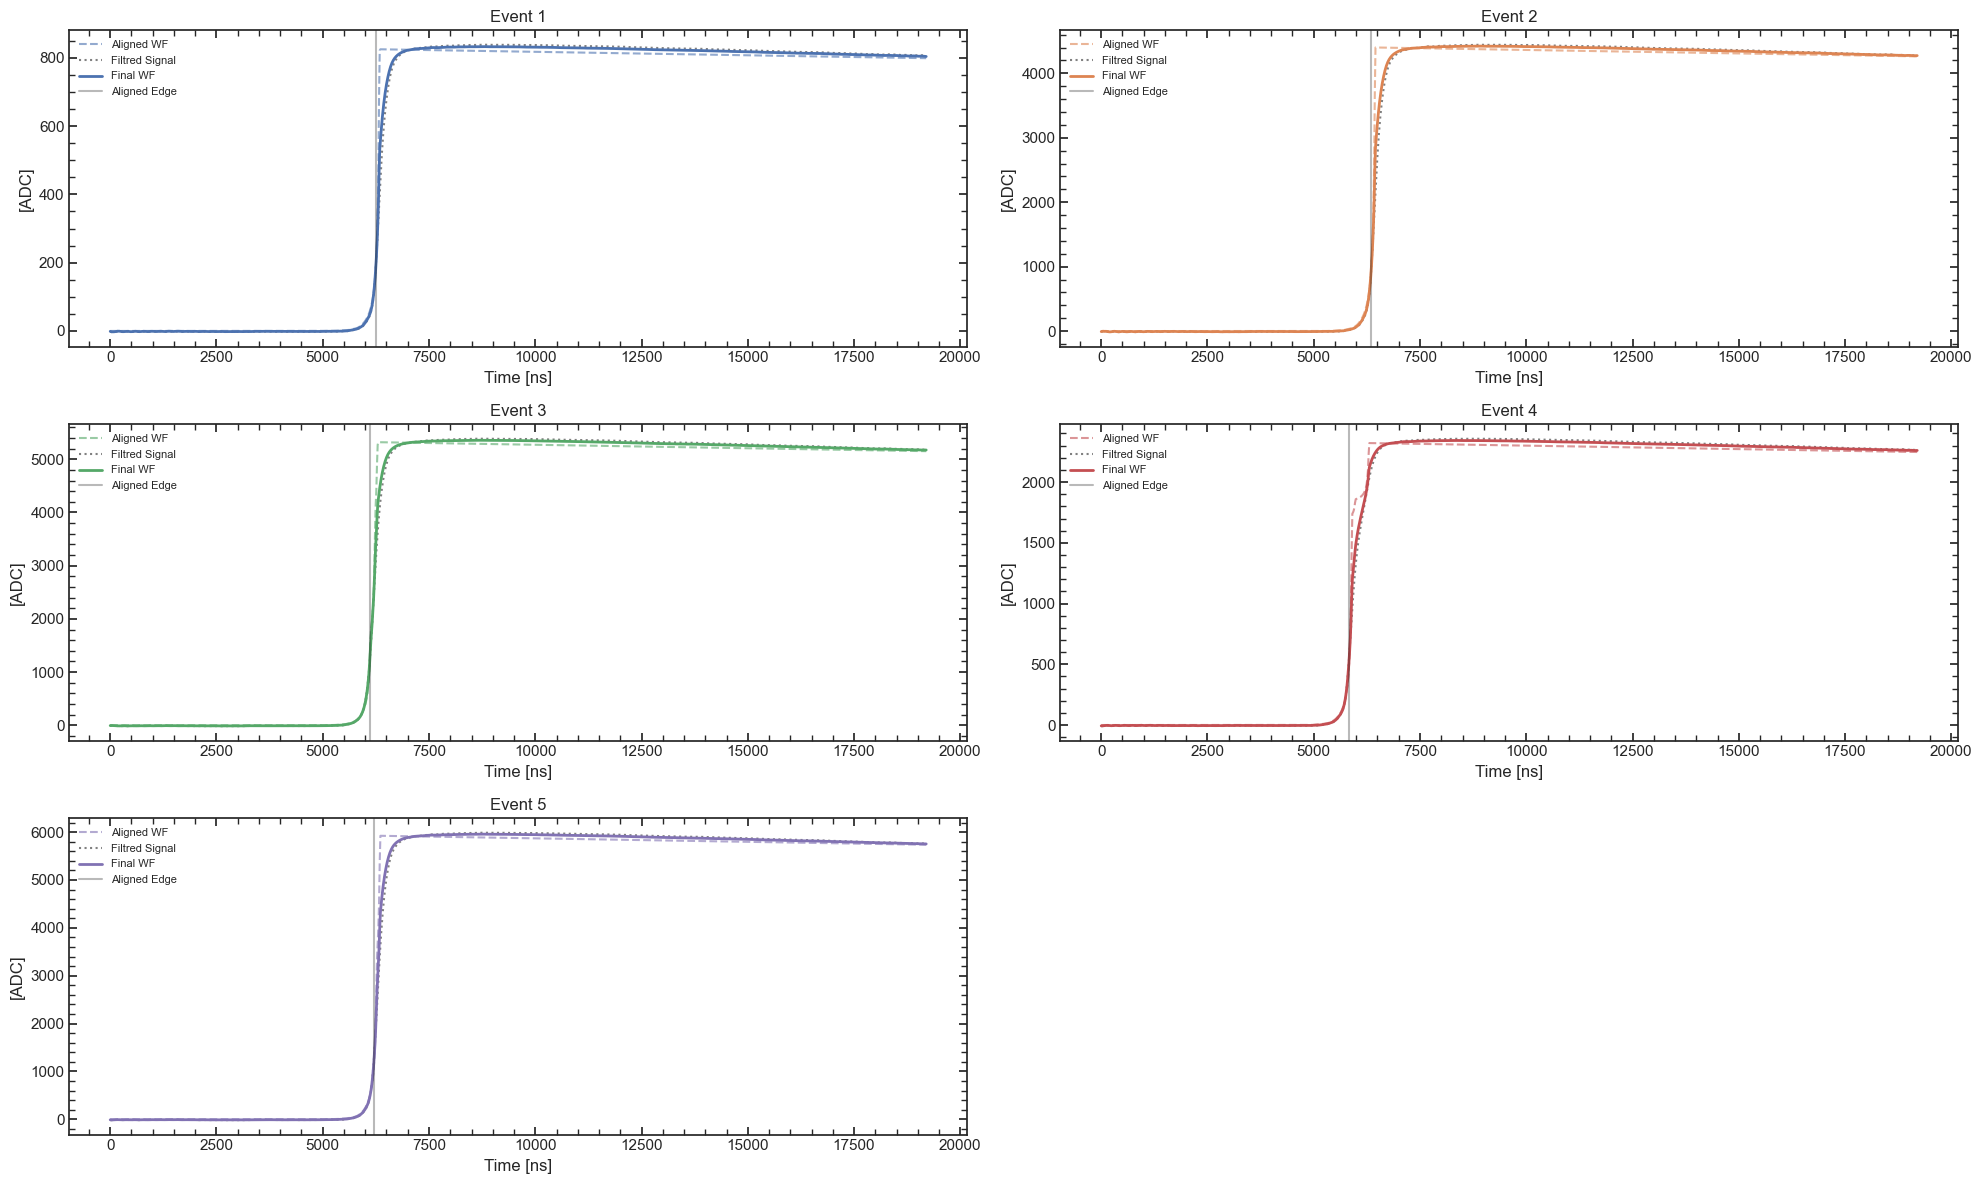

Alignment Results:
--------------------------------------------------
Mean time shift: 461.1294
Std time shift: 11.9819
Max time shift: 480.3431

Event 1: shift = 448.3202
Event 2: shift = 448.3202
Event 3: shift = 480.3431
Event 4: shift = 464.3317
Event 5: shift = 464.3317

Alignment Quality Metrics:
--------------------------------------------------
Average correlation before alignment: 0.9533
Average correlation after alignment: 0.9975


In [ ]:
align_method = 'threshold'
aligned_wfs, time_shifts = align_all_waveforms(wfs, signal_filtred_cutted, time_signal_filtred_cutted, method=align_method)         # align the waveforms to the rising edge of the filtered signal         

final_waveforms = np.zeros(signal_filtred_cutted.shape)

# Combine aligned waveforms and filtered signals with weights

w_1 = 0.3           # weight for aligned waveforms --> increase this to obtain a more sharp waveform
w_2 = 1 - w_1       # weight for filtered signals --> increase this to obtain a more smooth waveform (freq effects)

for i in range(final_waveforms.shape[0]):
    final_waveforms[i,:] =  w_1 * aligned_wfs[i,:] +  w_2 * signal_filtred_cutted[i,:]

plt.figure(figsize=(20, 12))
for i in range(wfs.shape[0]):
    plt.subplot(3, 2, i+1)
    
    plt.plot(time_signal_filtred_cutted, aligned_wfs[i], 'C'+str(i), linestyle='--', label='Aligned WF', alpha=0.6)
    plt.plot(time_signal_filtred_cutted, signal_filtred_cutted[i], color='gray', ls=':', label='Filtred Signal ', alpha=1)
    plt.plot(time_signal_filtred_cutted, final_waveforms[i], color = 'C'+str(i), lw=2, label='Final WF')
    aligned_edge_time, _ = find_rising_edge(aligned_wfs[i], time_signal_filtred_cutted, align_method)

    plt.axvline(aligned_edge_time, color='k', alpha=0.3, linestyle='-', label='Aligned Edge')

    plt.xlabel('Time [ns]')
    plt.ylabel('[ADC]')
    plt.title(f'Event {i+1}')
    plt.legend(fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

# Print alignment statistics
print("Alignment Results:")
print("-" * 50)
print(f"Mean time shift: {np.mean(time_shifts):.4f}")
print(f"Std time shift: {np.std(time_shifts):.4f}")
print(f"Max time shift: {np.max(np.abs(time_shifts)):.4f}")
print()

for i in range(min(10, len(time_shifts))):
    print(f"Event {i+1}: shift = {time_shifts[i]:.4f}")

# Calculate alignment quality metrics
print("\nAlignment Quality Metrics:")
print("-" * 50)

# Calculate cross-correlation at zero lag after alignment
correlations_before = []
correlations_after = []

for i in range(wfs.shape[0]):
    # Normalize signals for correlation
    wf_norm = (wfs[i] - np.mean(wfs[i])) / np.std(wfs[i])
    aligned_norm = (aligned_wfs[i] - np.mean(aligned_wfs[i])) / np.std(aligned_wfs[i])
    fit_norm = (signal_filtred_cutted[i] - np.mean(signal_filtred_cutted[i])) / np.std(signal_filtred_cutted[i])
    
    # Correlation before alignment
    corr_before = np.corrcoef(wf_norm, fit_norm)[0, 1]
    correlations_before.append(corr_before)
    
    # Correlation after alignment
    corr_after = np.corrcoef(aligned_norm, fit_norm)[0, 1]
    correlations_after.append(corr_after)

print(f"Average correlation before alignment: {np.mean(correlations_before):.4f}")
print(f"Average correlation after alignment: {np.mean(correlations_after):.4f}")

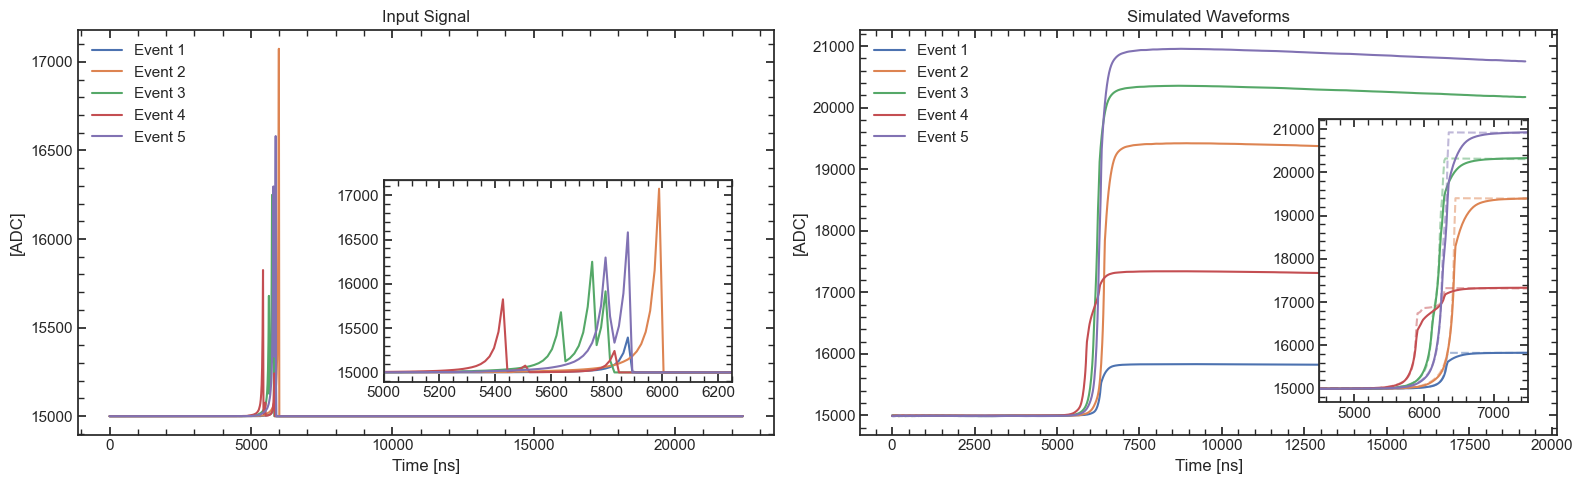

In [21]:
plt.figure(figsize=(16, 5))  

plt.subplot(1,2,1)
plt.title("Input Signal")
plt.xlabel("Time [ns]")
plt.ylabel("[ADC]")

for i in range(voltage_ADC.shape[0]):
    plt.plot(data_time,voltage_ADC[i]+15000, label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="50%", 
                    height="50%", 
                    bbox_to_anchor=(-0.05, -0.35, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(voltage_ADC.shape[0]):
    axins.plot(data_time,voltage_ADC[i]+15000, label=f"Event {i+1}")

axins.set_xlim(5000, 6250)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5");


plt.subplot(1,2,2)
plt.title("Simulated Waveforms")
plt.xlabel("Time [ns]")
plt.ylabel("[ADC]")

for i in range(voltage_ADC.shape[0]):
    plt.plot(time_signal_filtred_cutted, final_waveforms[i] + 15000, label=f"Event {i+1}")
plt.legend(frameon=False, loc='upper left')

axins = inset_axes(plt.gca(), 
                    width="30%", 
                    height="70%", 
                    bbox_to_anchor=(-0.03, -0.2, 1, 1),  # (x, y, width, height)
                    bbox_transform=plt.gca().transAxes)

for i in range(voltage_ADC.shape[0]):
    axins.plot(time_signal_filtred_cutted, (aligned_wfs[i]+signal_filtred_cutted[i])/2 + 15000)
    axins.plot(time_signal_filtred_cutted, aligned_wfs[i] + 15000, ls = '--', alpha=0.5, color= 'C'+str(i))

axins.set_xlim(4500, 7500)
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

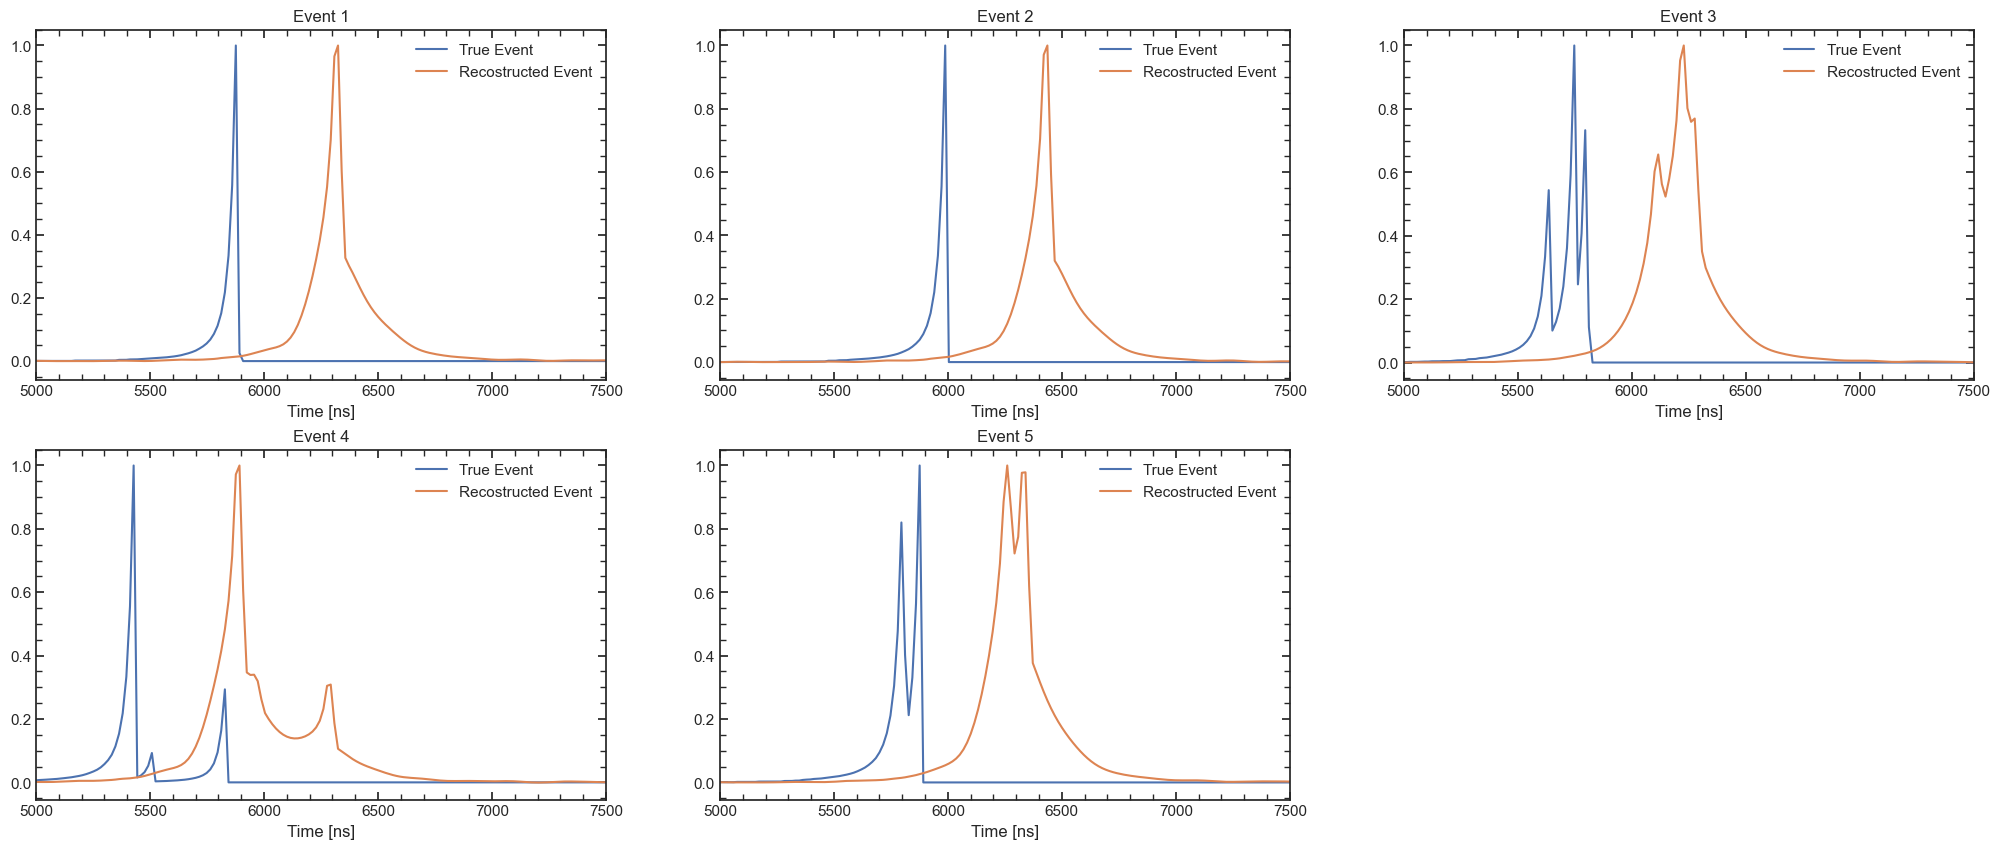

In [22]:
x = np.arange(final_waveforms.shape[1])
recostructed_signal = np.gradient(final_waveforms, x, axis=1) 

plt.figure(figsize=(25,10))
for i in range(recostructed_signal.shape[0]):
    plt.subplot(2, 3, i+1)
    plt.title(f"Event {i+1}")
    plt.plot(data_time,voltage_ADC[i]/np.max(voltage_ADC[i]), label='True Event')
    plt.plot(time_signal_filtred_cutted, recostructed_signal[i]/np.max(recostructed_signal[i]), label='Recostructed Event')
    plt.xlim(5000, 7500)
    plt.xlabel("Time [ns]")
    plt.legend(frameon=False);

## 5. Test with pulser data


In [ ]:
pulser_signals = np.zeros((len(df_data), len(df_data['input_signal'][0])))
pulser_waveforms = np.zeros_like(pulser_signals)

baseline_indx = int(len(df_data['input_signal'][0]) * 0.2)  # 20% of the signal length for baseline


for i in range(len(df_data)):
    pulser_signals[i,:] = df_data['input_signal'][i] - np.mean(df_data['input_signal'][i][:baseline_indx])  # subtract baseline
    pulser_waveforms[i,:] = df_data['waveform'][i] - np.mean(df_data['waveform'][i][:baseline_indx])        # subtract baseline

Real cutting freq: 5.007 MHz


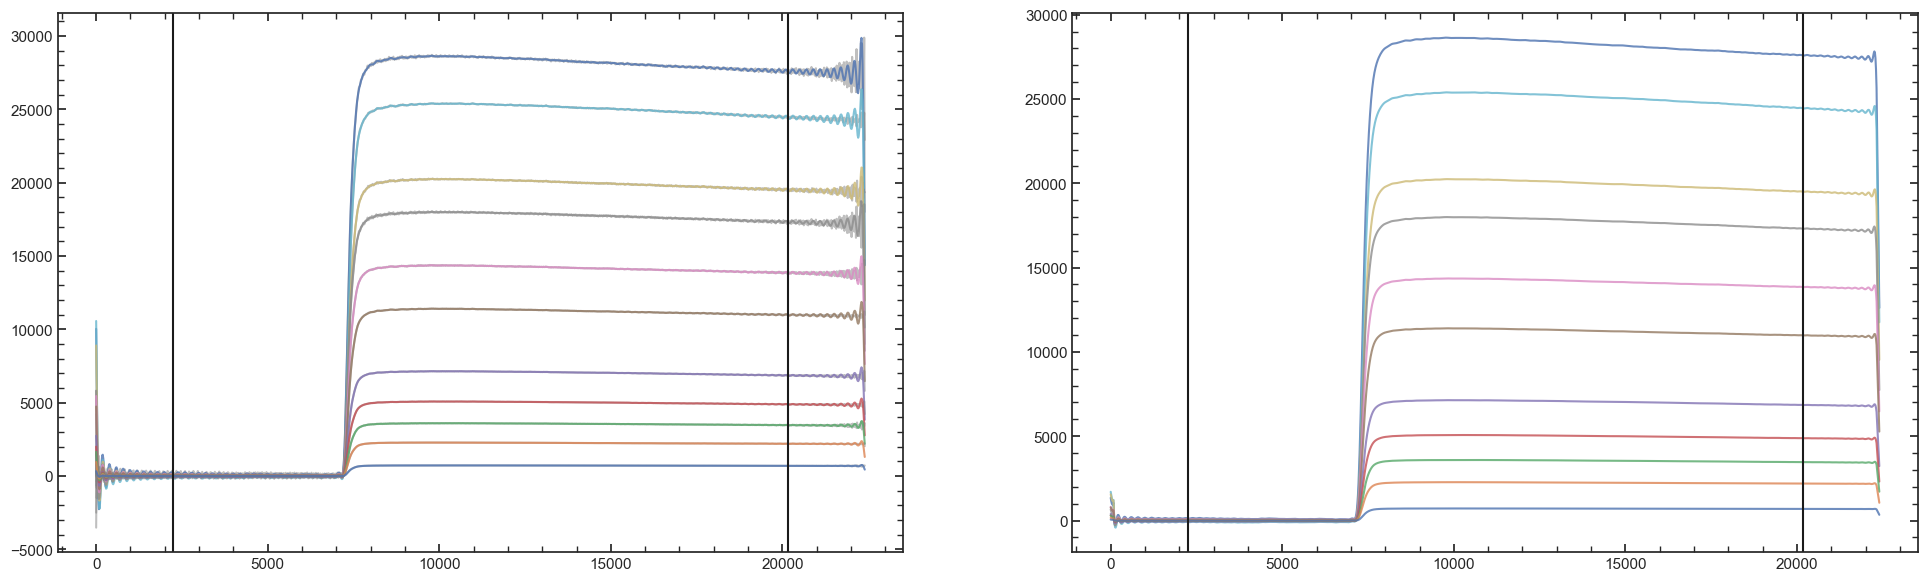

In [25]:
f_cut = 5*1e6 #Hz
N=len(data_time)
wnd_points = 11


th = 1/10

cut_1 = int(len(data_time) * th)
cut_2 = int(len(data_time) * (1-th))  

cc4_filter, cc4_freqs, cc4_freqs_shift = cc4_filter_builder(N)
cc4_filter_cutted, cc4_cut_freq = freq_cuts(cc4_filter, f_cut=f_cut)

print(f'Real cutting freq: {np.round(cut_freq_gesim,3)} MHz')

plt.figure(figsize=(24, 7))

plt.subplot(1,2,1)
for i in range(pulser_signals.shape[0])[::-1]:
    plt.plot(data_time, ifft(fft(pulser_signals[i])*cc4_filter), alpha=0.5, color = 'grey')
    plt.plot(data_time, ifft(fft(pulser_signals[i])*cc4_filter_cutted), alpha=0.8, color = 'C'+str(i))
    #plt.plot(data_time, pulser_waveforms[i], alpha=0.5, color = 'C'+str(i), ls='--')
plt.axvline(data_time[cut_1], color='k')
plt.axvline(data_time[cut_2], color='k')

plt.subplot(1,2,2)
for i in range(pulser_signals.shape[0])[::-1]:
    plt.plot(data_time, moving_average(ifft(fft(pulser_signals[i])*cc4_filter_cutted),wnd_points), alpha=0.8, color = 'C'+str(i))
plt.axvline(data_time[cut_1], color='k')
plt.axvline(data_time[cut_2], color='k');

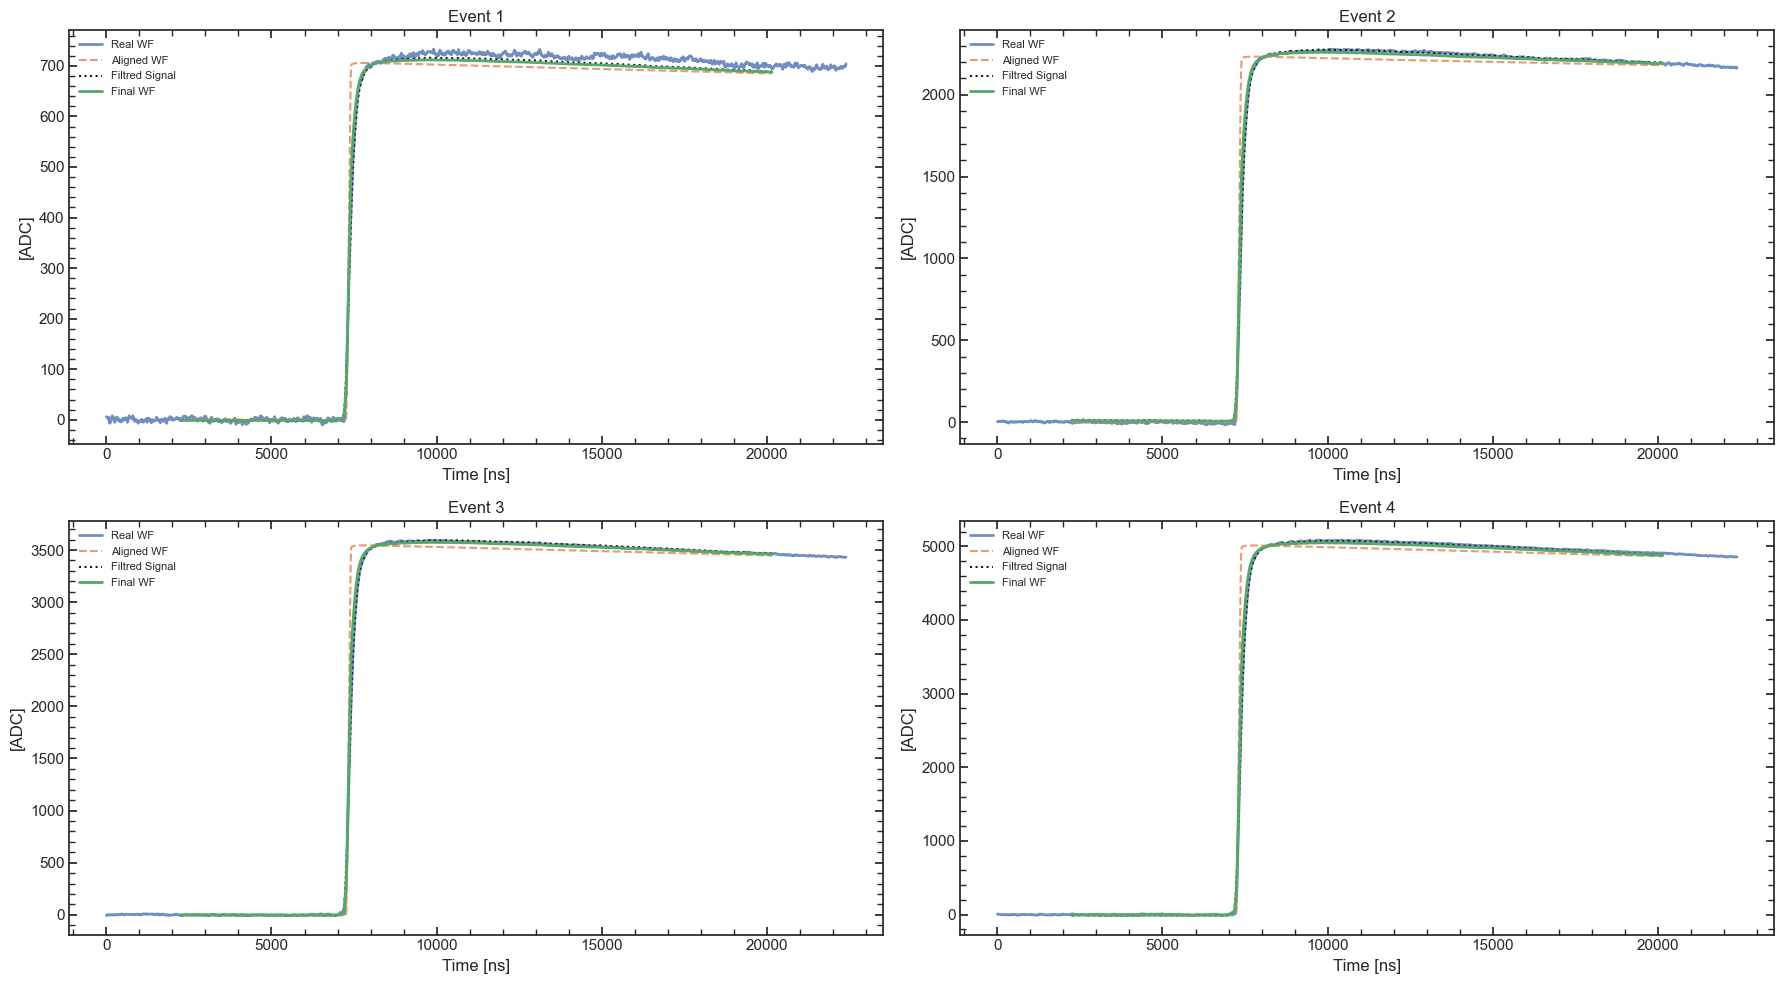

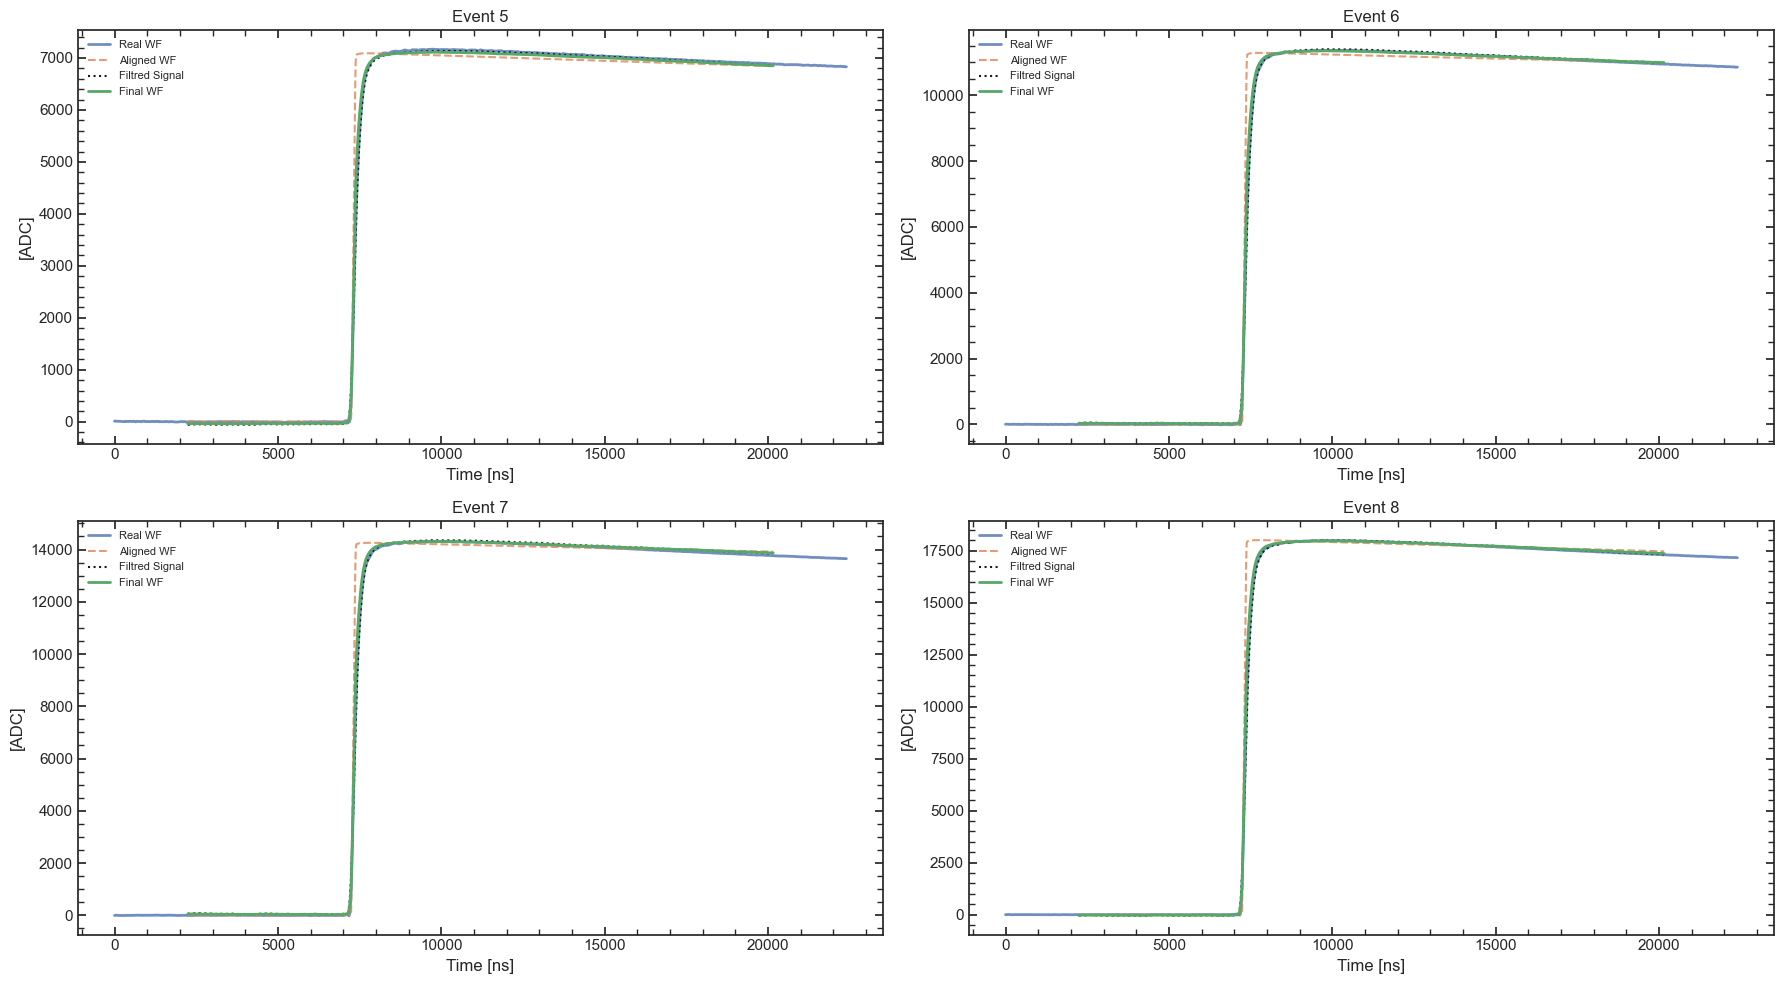

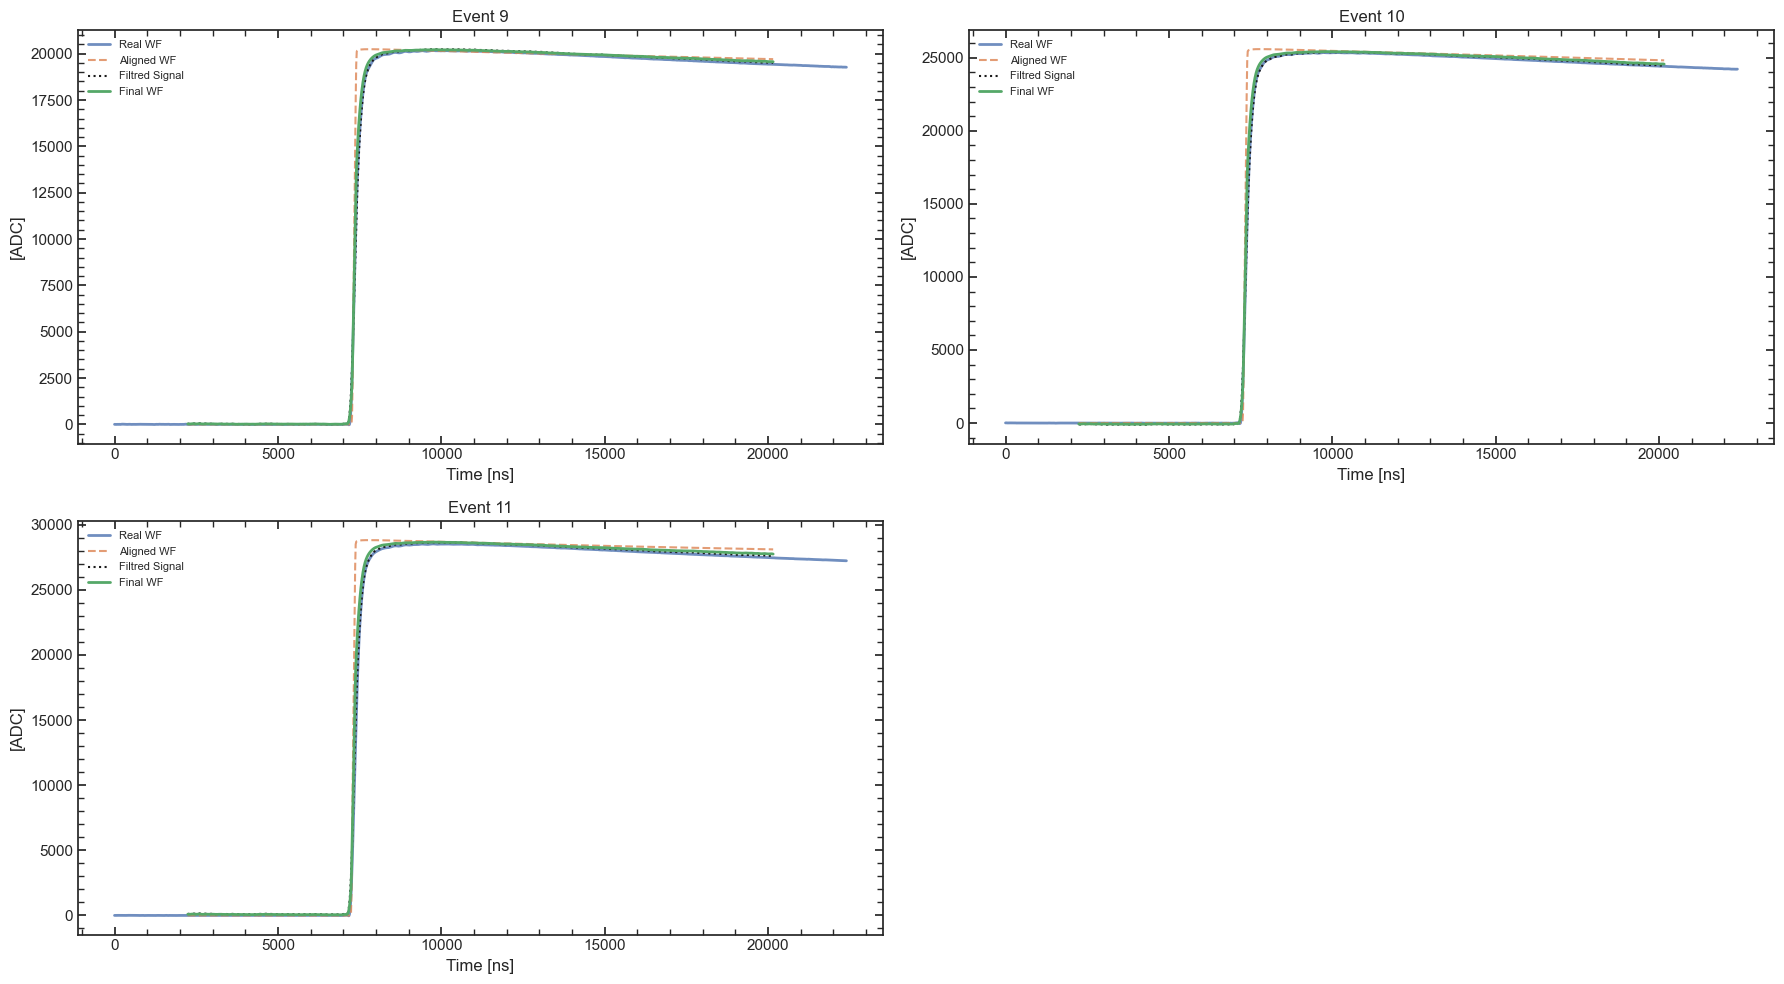

In [ ]:
pulser_signals_V = pulser_signals * ADC_to_V            # convert input signals to Volts for the CC4 simulation
dt = (data_time[1] - data_time[0])*1e-9                 # convert to seconds
data_time_cutted = data_time[cut_1:cut_2]


simulated_pulser_wfs = cc4(pulser_signals_V, dt, units="ADC", ADC_offset=0)[:,cut_1:cut_2] # simulated waveforms with no freqs effects
filtred_wfs = moving_average(ifft(fft(pulser_signals)*cc4_filter_cutted),wnd_points)[:,cut_1:cut_2] # apply the moving average to the filtred signal

align_method = 'threshold'
aligned_wfs, time_shifts = align_all_waveforms(simulated_pulser_wfs, filtred_wfs, data_time_cutted, method=align_method) 


final_waveforms = np.zeros(filtred_wfs.shape)

w_1 = 0.3
w_2 = 1 - w_1

for i in range(filtred_wfs.shape[0]):
    final_waveforms[i,:] = w_1 * aligned_wfs[i,:] + w_2 * filtred_wfs[i,:]


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(18, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(data_time, pulser_waveforms[i], lw=2, label='Real WF', alpha=0.8)
    plt.plot(data_time_cutted, aligned_wfs[i], linestyle='--', label='Aligned WF', alpha=0.8)
    plt.plot(data_time_cutted, filtred_wfs[i], color='k', ls=':', label='Filtred Signal ', alpha=1)
    plt.plot(data_time_cutted, final_waveforms[i], lw=2, label='Final WF', alpha=1)
    plt.xlabel('Time [ns]')
    plt.ylabel('[ADC]')
    plt.title(f'Event {i+1}')
    plt.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 10))
for i in range(4, 8):
    plt.subplot(2, 2, i-3)  
    plt.plot(data_time, pulser_waveforms[i], lw=2, label='Real WF', alpha=0.8)
    plt.plot(data_time_cutted, aligned_wfs[i], linestyle='--', label='Aligned WF', alpha=0.8)
    plt.plot(data_time_cutted, filtred_wfs[i], color='k', ls=':', label='Filtred Signal ', alpha=1)
    plt.plot(data_time_cutted, final_waveforms[i], lw=2, label='Final WF', alpha=1)
    plt.xlabel('Time [ns]')
    plt.ylabel('[ADC]')
    plt.title(f'Event {i+1}')
    plt.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 10))
for i in range(8, 11):
    plt.subplot(2, 2, i-7)  
    plt.plot(data_time, pulser_waveforms[i], lw=2, label='Real WF', alpha=0.8)
    plt.plot(data_time_cutted, aligned_wfs[i], linestyle='--', label='Aligned WF', alpha=0.8)
    plt.plot(data_time_cutted, filtred_wfs[i], color='k', ls=':', label='Filtred Signal ', alpha=1)
    plt.plot(data_time_cutted, final_waveforms[i], lw=2, label='Final WF', alpha=1)
    plt.xlabel('Time [ns]')
    plt.ylabel('[ADC]')
    plt.title(f'Event {i+1}')
    plt.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

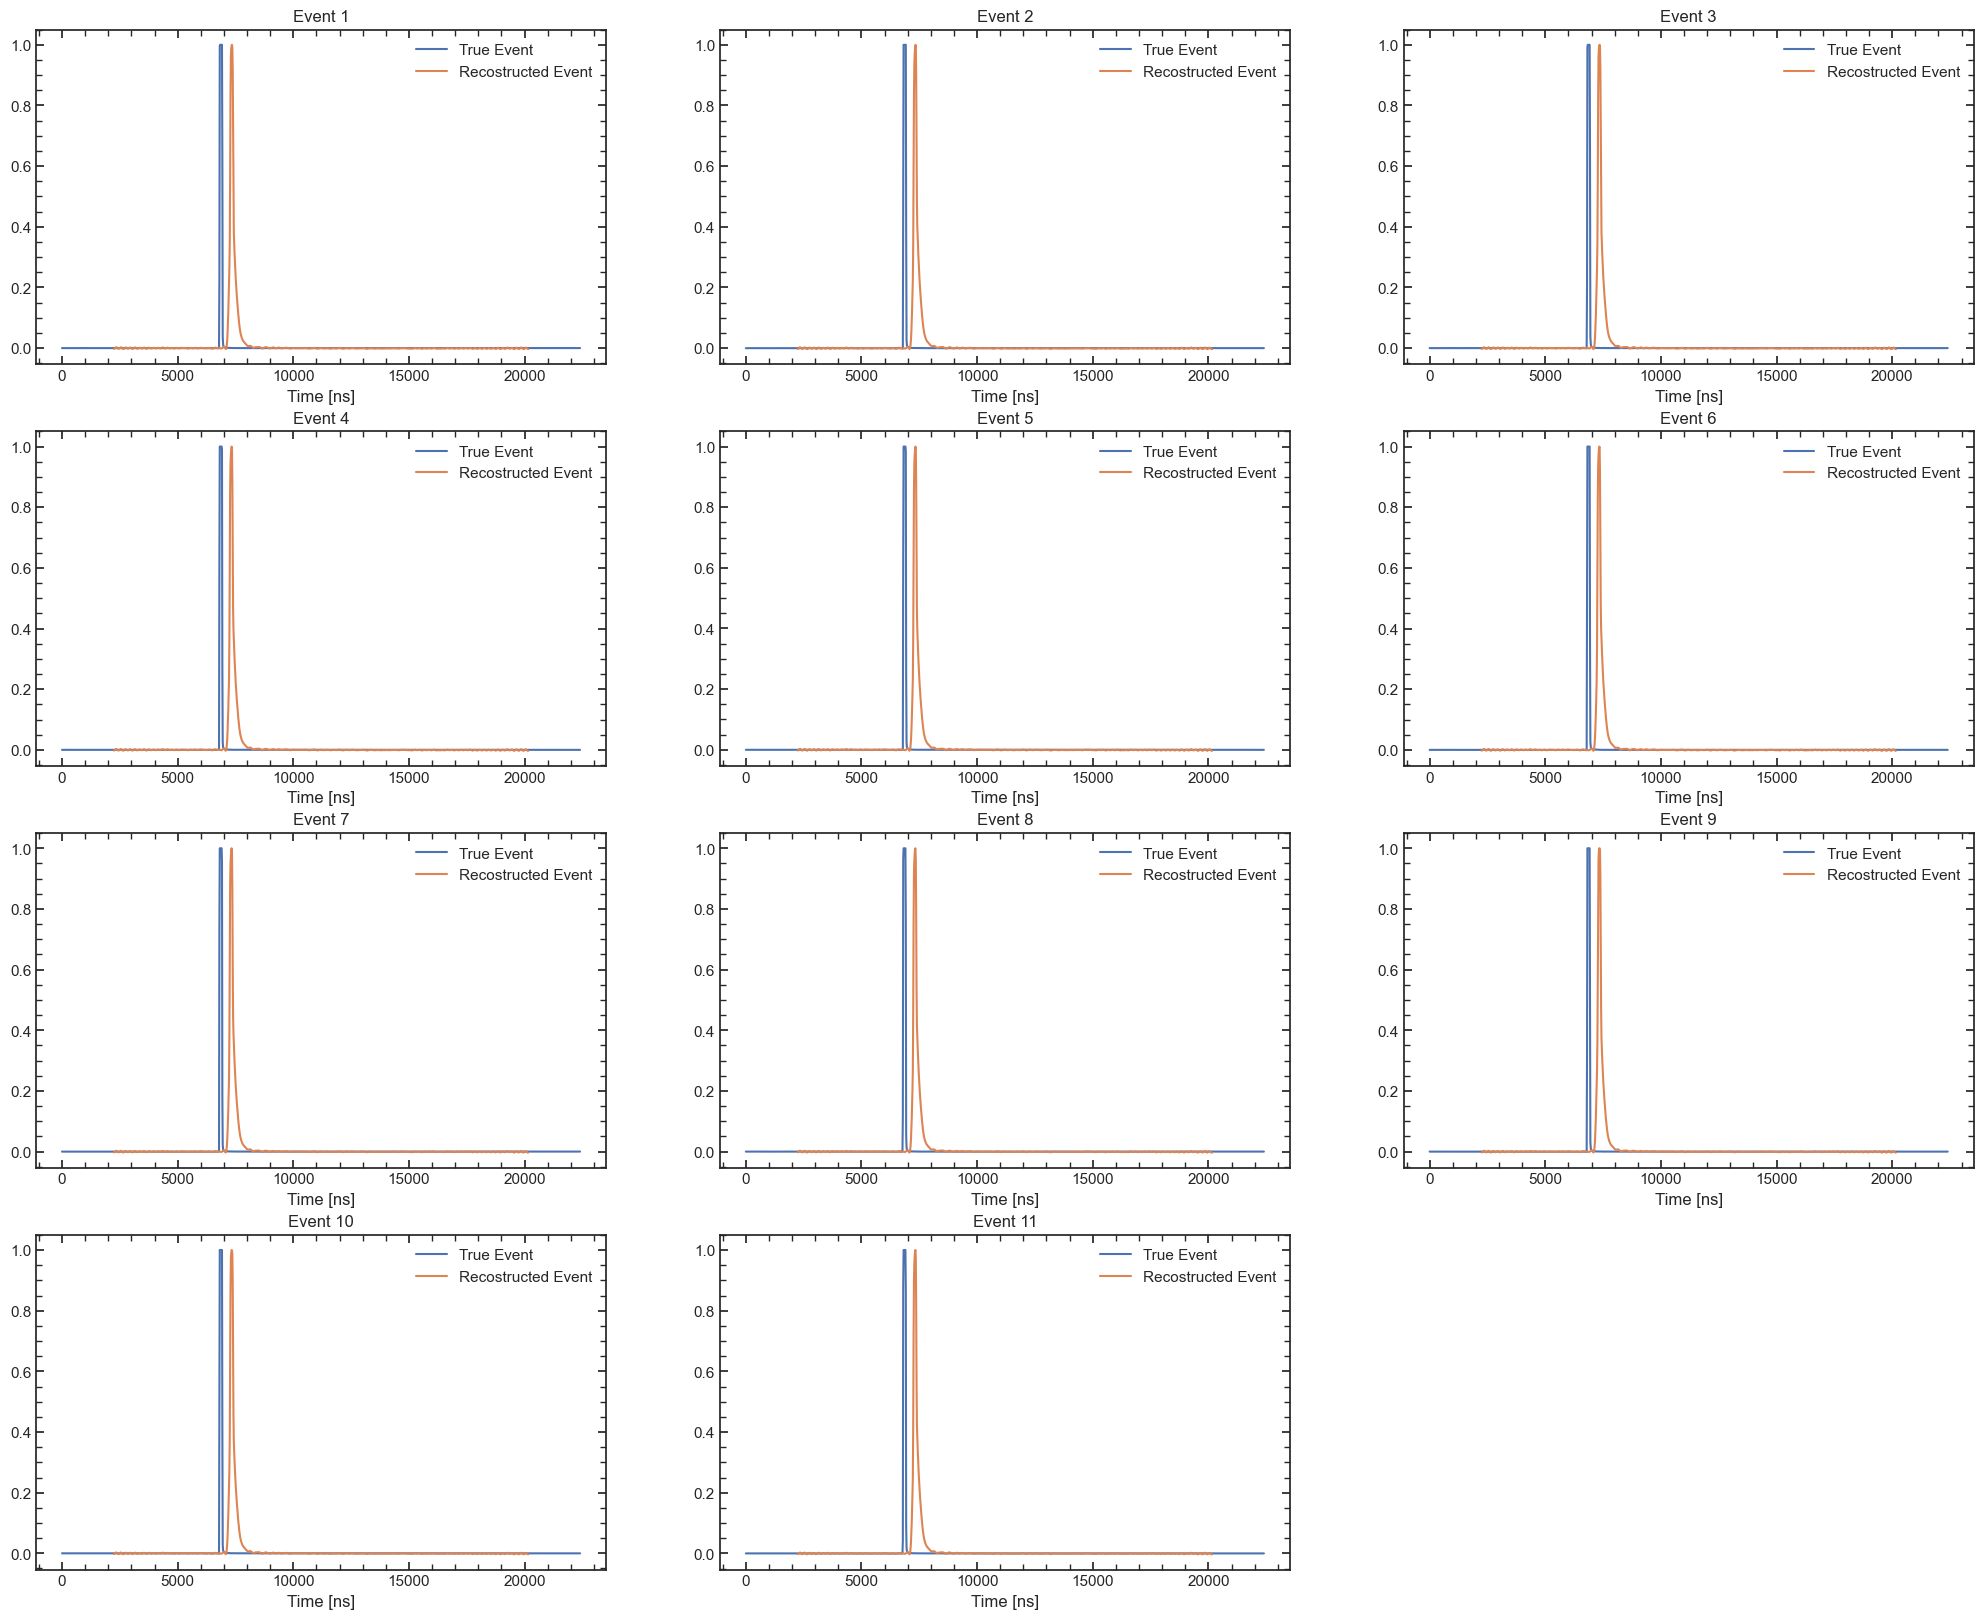

In [29]:
x = np.arange(final_waveforms.shape[1])
recostructed_signal = np.gradient(final_waveforms, x, axis=1) 

plt.figure(figsize=(25,20))
for i in range(recostructed_signal.shape[0]):
    plt.subplot(4, 3, i+1)
    plt.title(f"Event {i+1}")
    plt.plot(data_time,pulser_signals[i]/np.max(pulser_signals[i]), label='True Event')
    plt.plot(data_time_cutted, recostructed_signal[i]/np.max(recostructed_signal[i]), label='Recostructed Event')
    plt.legend(frameon=False)
    plt.xlabel("Time [ns]");
